## Table of Contents

1. [Problem Statement](#problem)
2. [Dataset Description](#description)
3. [Exploratory Data Analysis](#eda)
4. [Binary Classification](#binary)
5. [Multi-class Classification](#multi)
6. [Resampling](#resample)
7. [Conclusion](#conclusion)

## 1. **Problem Statement** <a id="problem"></a> 

Data Driven Methodology for Predictive Maintenance using the Dataset AI4I2020 is submitted towards the Studienarbeit for Mechatronics course at Universität Siegen. The goal of this work is to create a model which can accurately predict machine failure based on given data and provide an evaluation of the performance metrics. Questions that will be answered are -
1. Which model performs the best for binary classification?
2. Which model performs the best for multi-class classification?
3. Which features contribute to failure?
4. Which features result in a specific failure?
5. Does re-sampling really help?
6. How to evaluate the performance metrics?
7. Hyperparameter tuning?

## 2. **Dataset Description** <a id="description"></a> 

The dataset __"AI4I 2020 Predictive Maintenance Dataset"__ from the UCI Machine Learning Repository 2020, was presented by Dr. Stephan Matzka, School of Engineering - Technology and Life, Hochschule für Technik und Wirtschaft Berlin. The aim stated in the paper was to provide a realistic, yet synthetic, predictive maintenance dataset to reflect real predictive maintenance data encountered in industry. 
The dataset consists of 10,000 data points with 6 features and 6 failure indicators.
1) Product ID:
    consisting of letters L for low, M for medium and H for hgh product quality variants and a variant specific serial number.
    
2) Air temperature [K]:
    generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.
    
3) Process temperature [K]:
    generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
    
4) Rotational speed [rpm]:
    calculated from a power of 2860 W, overlaid with a normally distributed noise.
    
5) Torque [Nm]:
    torque values are normally distributed around 40 Nm with a σ = 10 Nm and no negative values.
    
6) Tool wear [min]:
    The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
    
    
Failure labels:
1) Machine failure:
    label that indicates whether the machine has failed at that particular datapoint.
    
2) TWF:
    Tool wear failure - the tool will fail or be replaced at a randomly selected tool wear time 200-240 mins in the dataset.
    
3) HDF:
    Heat dissipation failure - heat dissipation causes process failure, the air and process temperature difference exceeds 8.6 K and tool's rotational speed is below 1380 rpm.
    
4) PWF:
    Power failure - the product of Torque and Rotational speed i.e., the Power < 3500 W or  > 9000 W, the process fails.
    
5) OSF:
    Overstrain failure - if product of tool wear and torque exceeds 
    11,000 minNm for the L product variant 
    12,000 minNm for the M product variant 
    13,000 minNm for the H product variant,
    the process fails due to overstrain.
    
6) RNF:
    Random failure - 0.1% of process failure chance regardless of its parameters.

## 3. **Exploratory Data Analysis** <a id="eda"></a> 

In [1]:
# imports and set theme for the notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score, precision_score, recall_score, confusion_matrix, make_scorer, matthews_corrcoef, plot_confusion_matrix
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import export_graphviz
import graphviz

# read dataset into a dataframe

df = pd.read_csv("ai4i2020.csv")

### 3.1 General data overview

In [2]:
# preliminary checks

## information about the dataframe

df.info()

## shape of the dataset

df.shape

## columns in the dataset

df.columns

## first few records of the dataset

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [3]:
# statistical description of dataset

df.describe(include='all').T

count unique     top  freq       mean         std  \
UDI                      10000.0    NaN     NaN   NaN     5000.5  2886.89568   
Product ID                 10000  10000  M14860     1        NaN         NaN   
Type                       10000      3       L  6000        NaN         NaN   
Air temperature [K]      10000.0    NaN     NaN   NaN  300.00493    2.000259   
Process temperature [K]  10000.0    NaN     NaN   NaN  310.00556    1.483734   
Rotational speed [rpm]   10000.0    NaN     NaN   NaN  1538.7761  179.284096   
Torque [Nm]              10000.0    NaN     NaN   NaN   39.98691    9.968934   
Tool wear [min]          10000.0    NaN     NaN   NaN    107.951   63.654147   
Machine failure          10000.0    NaN     NaN   NaN     0.0339    0.180981   
TWF                      10000.0    NaN     NaN   NaN     0.0046    0.067671   
HDF                      10000.0    NaN     NaN   NaN     0.0115    0.106625   
PWF                      10000.0    NaN     NaN   NaN     0.0095    0.097009   
OSF                      10000.0    NaN     NaN   NaN     0.0098    0.098514   
RNF                      10000.0    NaN     NaN   NaN     0.0019     0.04355   

                            min      25%     50%      75%      max  
UDI                         1.0  2500.75  5000.5  7500.25  10000.0  
Product ID                  NaN      NaN     NaN      NaN      NaN  
Type                        NaN      NaN     NaN      NaN      NaN  
Air temperature [K]       295.3    298.3   300.1    301.5    304.5  
Process temperature [K]   305.7    308.8   310.1    311.1    313.8  
Rotational speed [rpm]   1168.0   1423.0  1503.0   1612.0   2886.0  
Torque [Nm]                 3.8     33.2    40.1     46.8     76.6  
Tool wear [min]             0.0     53.0   108.0    162.0    253.0  
Machine failure             0.0      0.0     0.0      0.0      1.0  
TWF                         0.0      0.0     0.0      0.0      1.0  
HDF                         0.0      0.0     0.0      0.0      1.0  
PWF                         0.0      0.0     0.0      0.0      1.0  
OSF                         0.0      0.0     0.0      0.0      1.0  
RNF                         0.0      0.0     0.0      0.0      1.0

In [4]:
# set numeric data columns as float

df['Rotational speed [rpm]'] = df['Rotational speed [rpm]'].astype('float64')
df['Tool wear [min]'] = df['Tool wear [min]'].astype('float64')

In [5]:
# rename features to remove the square brackets for ease of understanding and for XGBoost classifier

df.rename(columns = {'Air temperature [K]': 'Air temperature',
                     'Process temperature [K]': 'Process temperature',
                     'Rotational speed [rpm]': 'Rotational speed',
                     'Torque [Nm]': 'Torque',
                     'Tool wear [min]': 'Tool wear'}, inplace = True)

In [6]:
## find missing values in columns

df.isnull().sum()

UDI                    0
Product ID             0
Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Machine failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

There are no missing values in the columns

In [7]:
# find unique values in columns

df.nunique()

UDI                    10000
Product ID             10000
Type                       3
Air temperature           93
Process temperature       82
Rotational speed         941
Torque                   577
Tool wear                246
Machine failure            2
TWF                        2
HDF                        2
PWF                        2
OSF                        2
RNF                        2
dtype: int64

In [8]:
# check for duplicate rows for Product ID

df['Product ID'].nunique()

10000

In [9]:
# duplicate search

df[df.duplicated()]

Empty DataFrame
Columns: [UDI, Product ID, Type, Air temperature, Process temperature, Rotational speed, Torque, Tool wear, Machine failure, TWF, HDF, PWF, OSF, RNF]
Index: []

There are no duplicate values in the dataset.

### 3.2 Machine failure and its types overview

In [10]:
# value counts for the various types of failure 

tool_wear_range = df.loc[df['TWF'] == 1, 'Tool wear'].squeeze()
print("Minimum Tool wear for TWF: ",tool_wear_range.min())
print("Maximum Tool wear for TWF: ",tool_wear_range.max())

Minimum Tool wear for TWF:  198.0
Maximum Tool wear for TWF:  253.0


In [11]:
temp_rot_range = df.loc[df['HDF'] == 1]
# df['Air temperature']-df['Process temperature']< 8.6 && 'Rotational speed' < 1380
#temp_rot_range[['Air temperature','Process temperature', 'Rotational speed']]
temp_rot_range['Temp difference'] = (temp_rot_range['Air temperature'] - temp_rot_range['Process temperature'])

print("Maximum Rotational speed for HDF: ", temp_rot_range['Rotational speed'].max())
print("Minimum Temperature difference for HDF: ", temp_rot_range['Temp difference'].min())
#print("Maximum Temperature difference for HDF: ", temp_rot_range['Temp difference'].max())

Maximum Rotational speed for HDF:  1379.0
Minimum Temperature difference for HDF:  -8.599999999999966


In [12]:
power_range = df.loc[df['PWF'] == 1].squeeze()
#'Torque'*'Rotational speed'
#power_range[['Type','Torque','Rotational speed']]
power_range['Power'] = power_range['Torque'] * power_range['Rotational speed']
print("Minimum Power for PWF:", power_range['Power'].min())
print("Maximum Power for PWF:", power_range['Power'].max())

# power < 3500 or power > 9000
#power_range[power_range['Power']>9000]

Minimum Power for PWF: 10966.8
Maximum Power for PWF: 99980.40000000001


In [13]:
tool_wear_hold = df.loc[df['OSF'] == 1].squeeze()
#'Tool wear' * 'Torque'
#tool_wear_range[['Type','Tool wear','Torque']]
tool_wear_hold['Overstrain'] = tool_wear_hold['Tool wear'] * tool_wear_hold['Torque']

tool_wear_L = tool_wear_hold[tool_wear_hold['Type'] == 'L']
tool_wear_M = tool_wear_hold[tool_wear_hold['Type'] == 'M']
tool_wear_H = tool_wear_hold[tool_wear_hold['Type'] == 'H']

print("Minimum overstrain for Type L: ", tool_wear_L['Overstrain'].min())
print("Minimum overstrain for Type M: ", tool_wear_M['Overstrain'].min())
print("Minimum overstrain for Type H: ", tool_wear_H['Overstrain'].min())

Minimum overstrain for Type L:  11003.199999999999
Minimum overstrain for Type M:  12337.2
Minimum overstrain for Type H:  13234.8


In [14]:
# viewing data for Random failures 

df[df['RNF']==1]

UDI Product ID Type  Air temperature  Process temperature  \
1221  1222     M16081    M            297.0                308.3   
1302  1303     L48482    L            298.6                309.8   
1748  1749     H31162    H            298.4                307.7   
2072  2073     L49252    L            299.6                309.5   
2559  2560     L49739    L            299.3                309.0   
3065  3066     M17925    M            300.1                309.2   
3452  3453     H32866    H            301.6                310.5   
3611  3612     L50791    L            301.7                310.9   
5471  5472     L52651    L            302.7                312.3   
5489  5490     L52669    L            302.6                312.1   
5495  5496     H34909    H            302.9                312.5   
5509  5510     L52689    L            302.8                312.2   
5553  5554     L52733    L            302.5                311.9   
5639  5640     L52819    L            302.6                312.1   
6091  6092     L53271    L            300.9                310.7   
6913  6914     L54093    L            300.8                311.2   
6960  6961     L54140    L            300.7                311.0   
7488  7489     L54668    L            300.3                311.7   
7868  7869     H37282    H            300.4                311.9   

      Rotational speed  Torque  Tool wear  Machine failure  TWF  HDF  PWF  \
1221            1399.0    46.4      132.0                0    0    0    0   
1302            1505.0    45.7      144.0                0    0    0    0   
1748            1626.0    31.1      166.0                0    0    0    0   
2072            1570.0    35.5      189.0                0    0    0    0   
2559            1447.0    50.4      140.0                0    0    0    0   
3065            1687.0    27.7       95.0                0    0    0    0   
3452            1602.0    32.3        2.0                0    0    0    0   
3611            1405.0    46.4      207.0                1    1    0    0   
5471            1346.0    61.2      170.0                0    0    0    0   
5489            1499.0    35.0      215.0                0    0    0    0   
5495            1357.0    55.0       12.0                0    0    0    0   
5509            1509.0    36.5       52.0                0    0    0    0   
5553            1306.0    59.7      172.0                0    0    0    0   
5639            1668.0    28.7      180.0                0    0    0    0   
6091            1412.0    57.5       16.0                0    0    0    0   
6913            1481.0    38.5      181.0                0    0    0    0   
6960            1413.0    52.0       91.0                0    0    0    0   
7488            1545.0    43.5      160.0                0    0    0    0   
7868            1438.0    46.7       41.0                0    0    0    0   

      OSF  RNF  
1221    0    1  
1302    0    1  
1748    0    1  
2072    0    1  
2559    0    1  
3065    0    1  
3452    0    1  
3611    0    1  
5471    0    1  
5489    0    1  
5495    0    1  
5509    0    1  
5553    0    1  
5639    0    1  
6091    0    1  
6913    0    1  
6960    0    1  
7488    0    1  
7868    0    1

In [15]:
# value counts for each type of failure

print("Tool Wear Failure TWF:\n", df['TWF'].value_counts())
print("Heat Dissipation Failure HDF:\n", df['HDF'].value_counts())
print("Power Failure PWF:\n", df['PWF'].value_counts())
print("Overstrain Failure OSF:\n", df['OSF'].value_counts())
print("Random Failure RNF:\n", df['RNF'].value_counts())

# total 373

Tool Wear Failure TWF:
 0    9954
1      46
Name: TWF, dtype: int64
Heat Dissipation Failure HDF:
 0    9885
1     115
Name: HDF, dtype: int64
Power Failure PWF:
 0    9905
1      95
Name: PWF, dtype: int64
Overstrain Failure OSF:
 0    9902
1      98
Name: OSF, dtype: int64
Random Failure RNF:
 0    9981
1      19
Name: RNF, dtype: int64


In [16]:
df['Machine failure'].value_counts()

# total 339 - 34 missing failures (18 from RNF 16 unknown)

0    9661
1     339
Name: Machine failure, dtype: int64

In [17]:
# encoding Failure type based on the columns to have all the data in one column

conditions = [(df['TWF']==1),(df['HDF']==1),(df['PWF']==1),(df['OSF']==1),(df['RNF']==1)]
values = [1,2,3,4,5]

df['Failure type'] = np.select(conditions, values)

df['Failure type'].value_counts()

0    9652
2     115
3      91
4      78
1      46
5      18
Name: Failure type, dtype: int64

### 3.3 Ambiguous data removal

In [18]:
# ambiguous data where one of the failures is flagged but it does not report as Machine failure

idx_MF=df.loc[(df['Machine failure'] == 0) & ((df['TWF'] == 1) | 
                                              (df['HDF'] == 1) | 
                                              (df['PWF'] == 1) | 
                                              (df['OSF'] == 1) | 
                                              (df['RNF'] == 1))].index
df.loc[idx_MF]
num_drop_MF=df.loc[idx_MF].shape[0]

# drop these records
df.drop(index=idx_MF, inplace=True)
print('Number of records dropped for data where one of the failure is flagged but is not reported as a Machine failure:', num_drop_MF)


# ambiguous data where Machine failure is flagged without specifying the reason of failure

idx_RMF=df.loc[(df['Machine failure'] == 1) & ((df['TWF'] == 0) & 
                                               (df['HDF'] == 0) & 
                                               (df['PWF'] == 0) & 
                                               (df['OSF'] == 0) & 
                                               (df['RNF'] == 0))].index
df.loc[idx_RMF]
num_drop_RMF=df.loc[idx_RMF].shape[0]

# drop these records
df.drop(index=idx_RMF, inplace=True)
print('Number of records dropped for data where Machine failure is reported without specifying the reason for failure:', num_drop_RMF)

Number of records dropped for data where one of the failure is flagged but is not reported as a Machine failure: 18
Number of records dropped for data where Machine failure is reported without specifying the reason for failure: 9


### 3.4 Plots for different data distributions

[Text(0, 0, '5984'), Text(0, 0, '2991'), Text(0, 0, '998')]

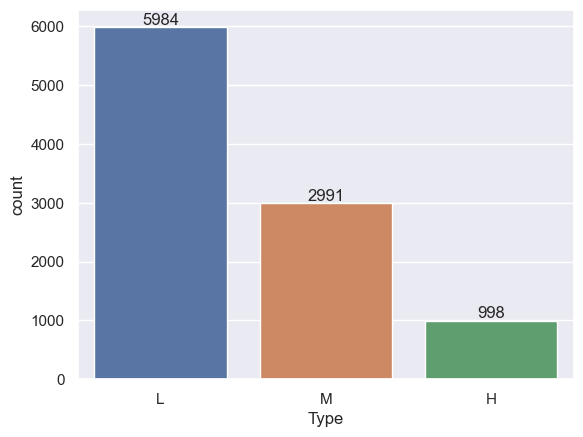

In [19]:
# count plot to check the data distribution over different Types of machines

count_plot = sns.countplot(x='Type', data=df, order=['L','M','H'])
count_plot.bar_label(count_plot.containers[0])

<AxesSubplot:xlabel='Tool wear', ylabel='Count'>

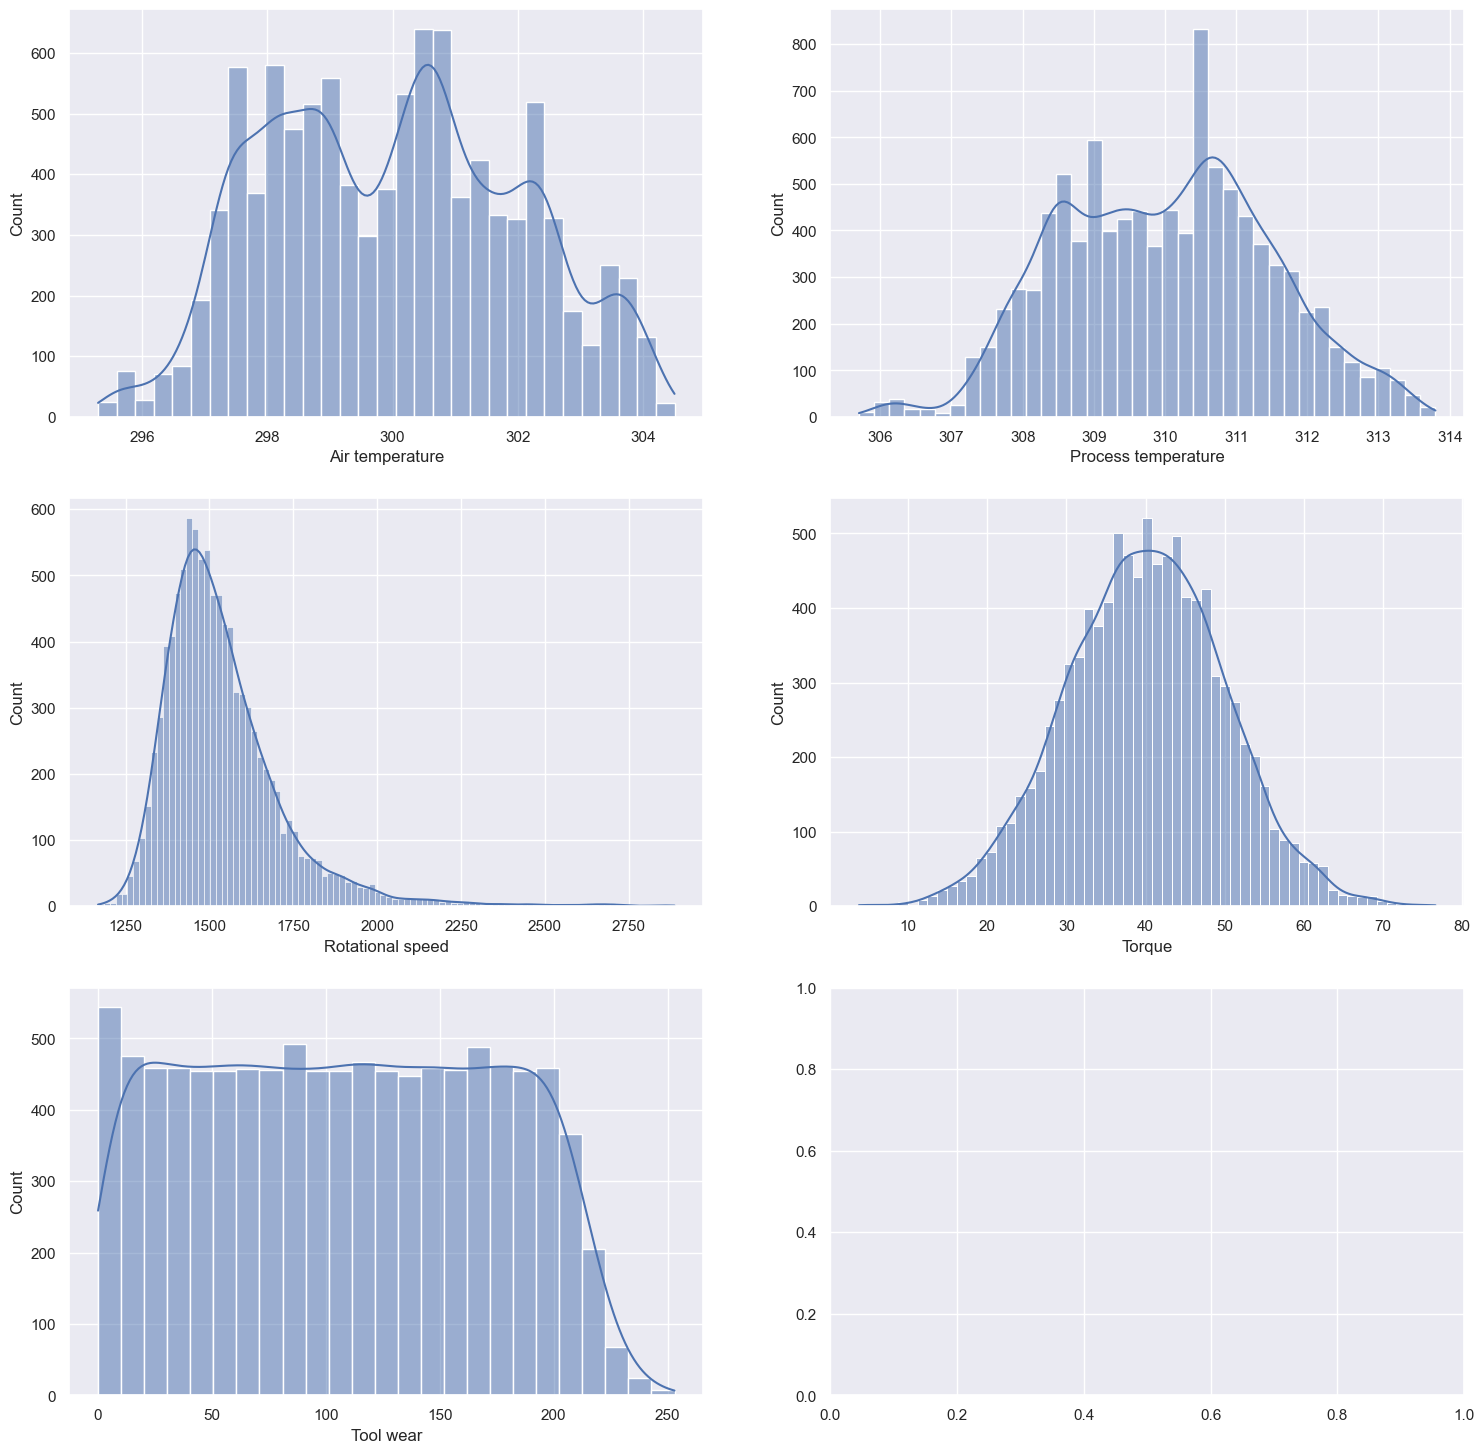

In [20]:
# Numerical feature distribution

fig, axs = plt.subplots(3,2, figsize=(18,18))

sns.histplot(df['Air temperature'], kde=True, ax=axs[0, 0])
sns.histplot(df['Process temperature'], kde=True, ax=axs[0, 1])
sns.histplot(df['Rotational speed'], kde=True, ax=axs[1, 0])
sns.histplot(df['Torque'], kde=True, ax=axs[1, 1])
sns.histplot(df['Tool wear'], kde=True, ax=axs[2, 0])

Rotational speed [rpm] and Tool wear [min] are observed to be skewed to left.

<AxesSubplot:xlabel='Tool wear'>

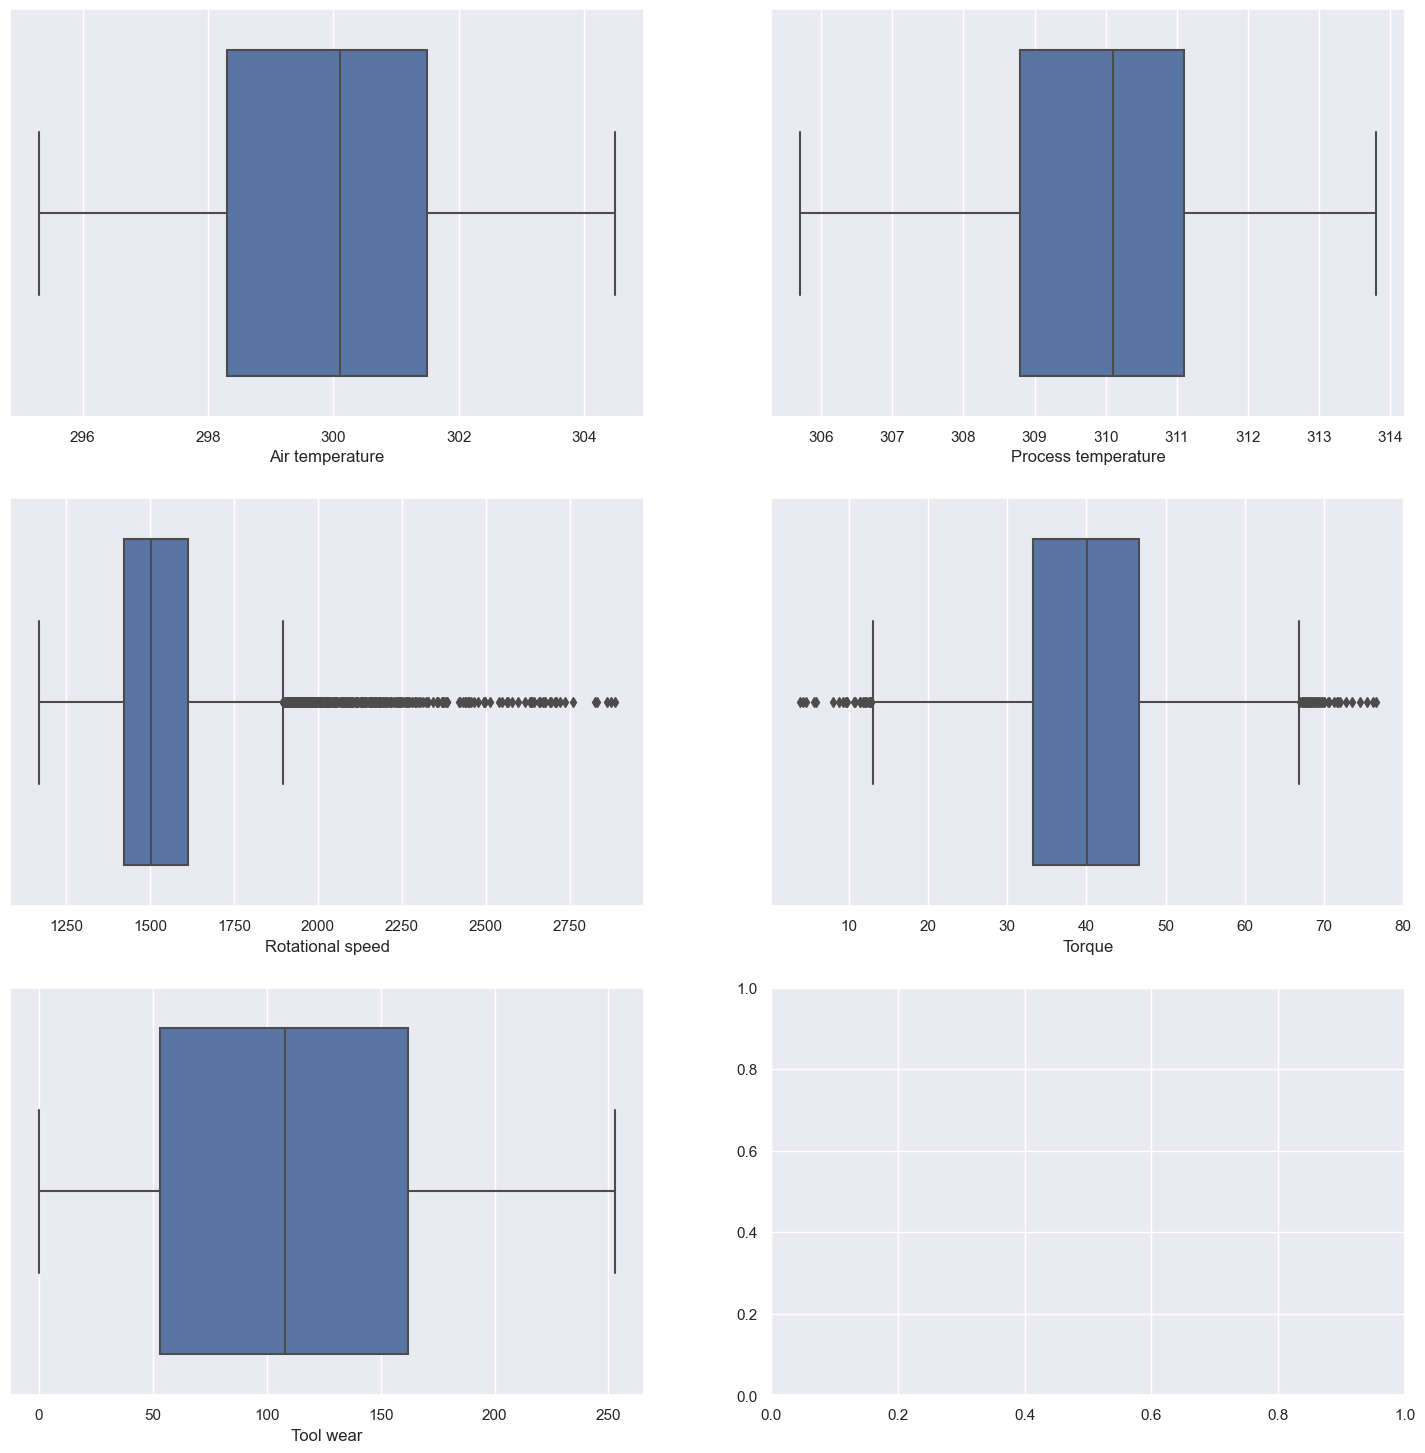

In [21]:
# Outliers

# Boxplots for numerical features
fig, axs = plt.subplots(3, 2, figsize=(18, 18))

sns.boxplot(x=df['Air temperature'], ax=axs[0, 0])
sns.boxplot(x=df['Process temperature'], ax=axs[0, 1])
sns.boxplot(x=df['Rotational speed'], ax=axs[1, 0])
sns.boxplot(x=df['Torque'], ax=axs[1, 1])
sns.boxplot(x=df['Tool wear'], ax=axs[2, 0])

Outliers are identified in Rotational speed [rpm] and Torque [rpm] as expected from the skewed Gaussian distribution for Rotational speed [rpm].

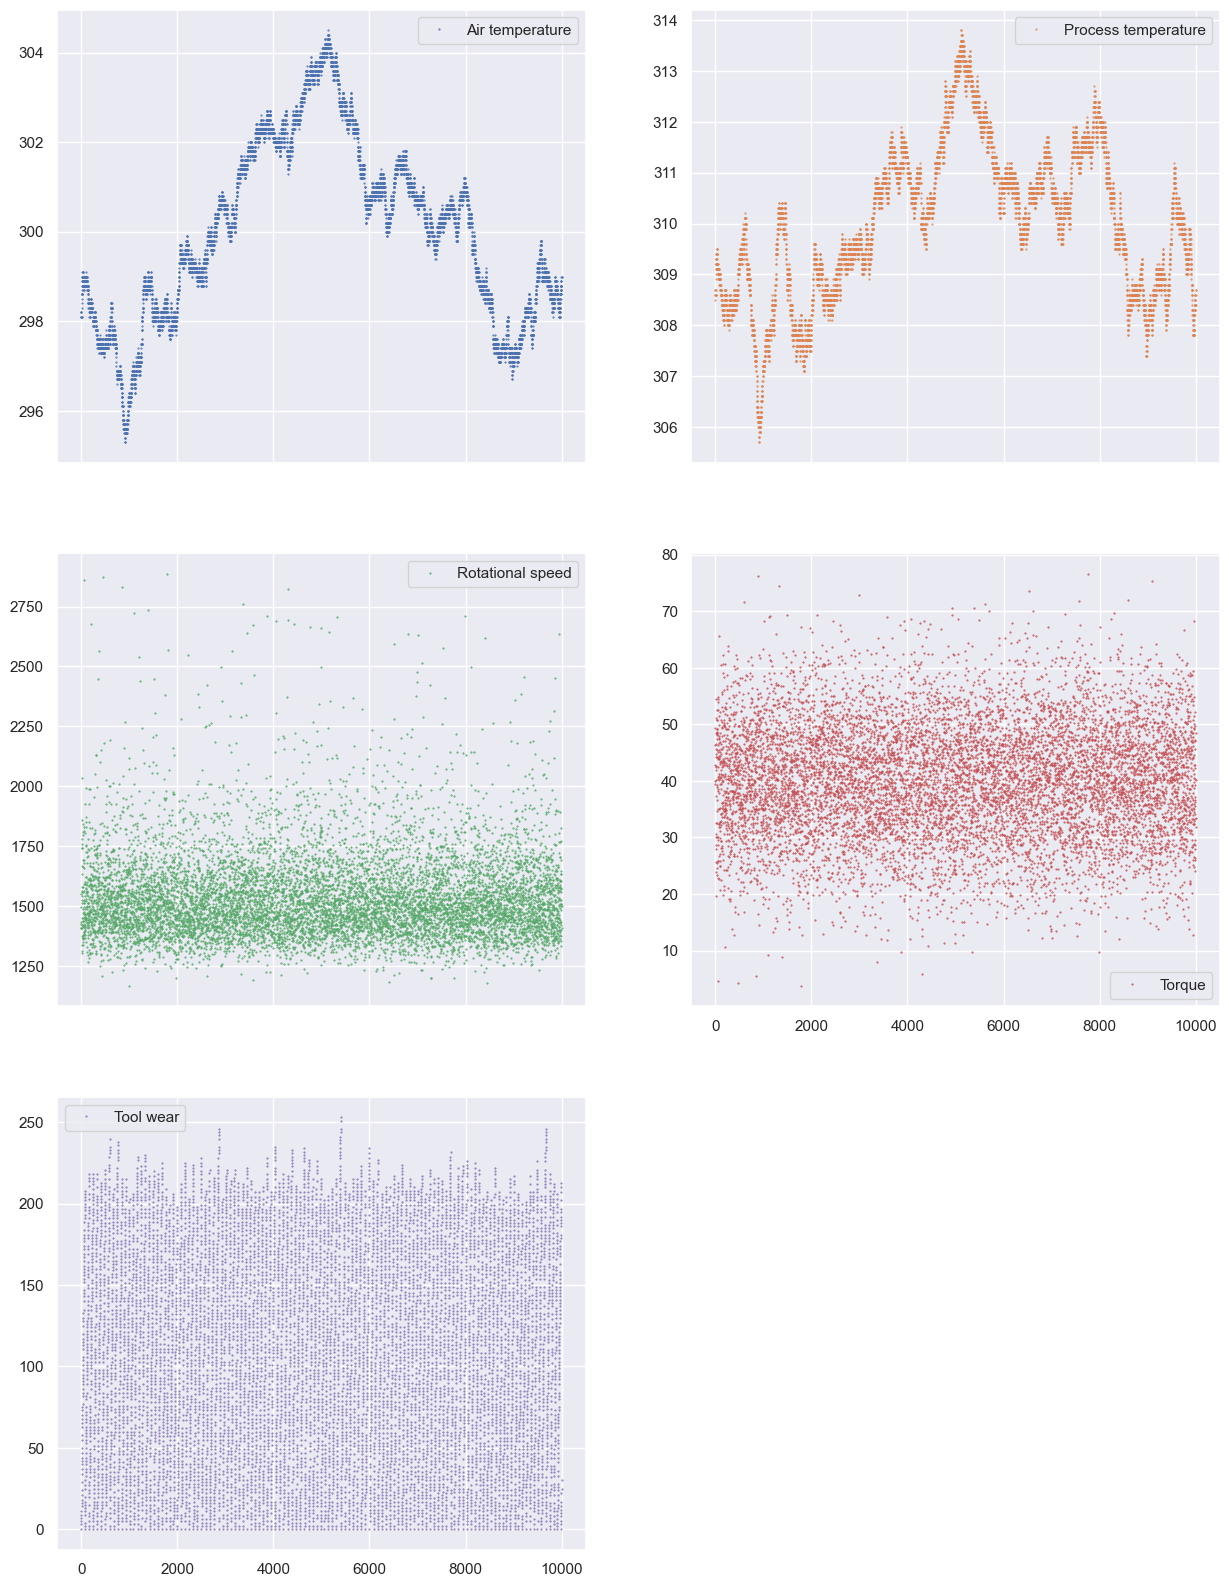

In [22]:
# plot distribution

df[["Air temperature","Process temperature","Rotational speed","Torque","Tool wear"]].plot(lw=0, marker=".", subplots=True, layout=(-1,2),
          figsize=(15, 20), markersize=1);

In [23]:
# Feature Encoding - Type 

type_dict ={'L':0, 'M':1, 'H':2}
df['Type'].replace(to_replace=type_dict, inplace=True)

In [24]:
df['Failure type'].value_counts()

0    9643
2     115
3      91
4      78
1      46
Name: Failure type, dtype: int64

In [25]:
# dropping unnecessary data

df.drop(columns=['UDI','Product ID','TWF','HDF','PWF','OSF','RNF'], inplace=True)

<AxesSubplot:>

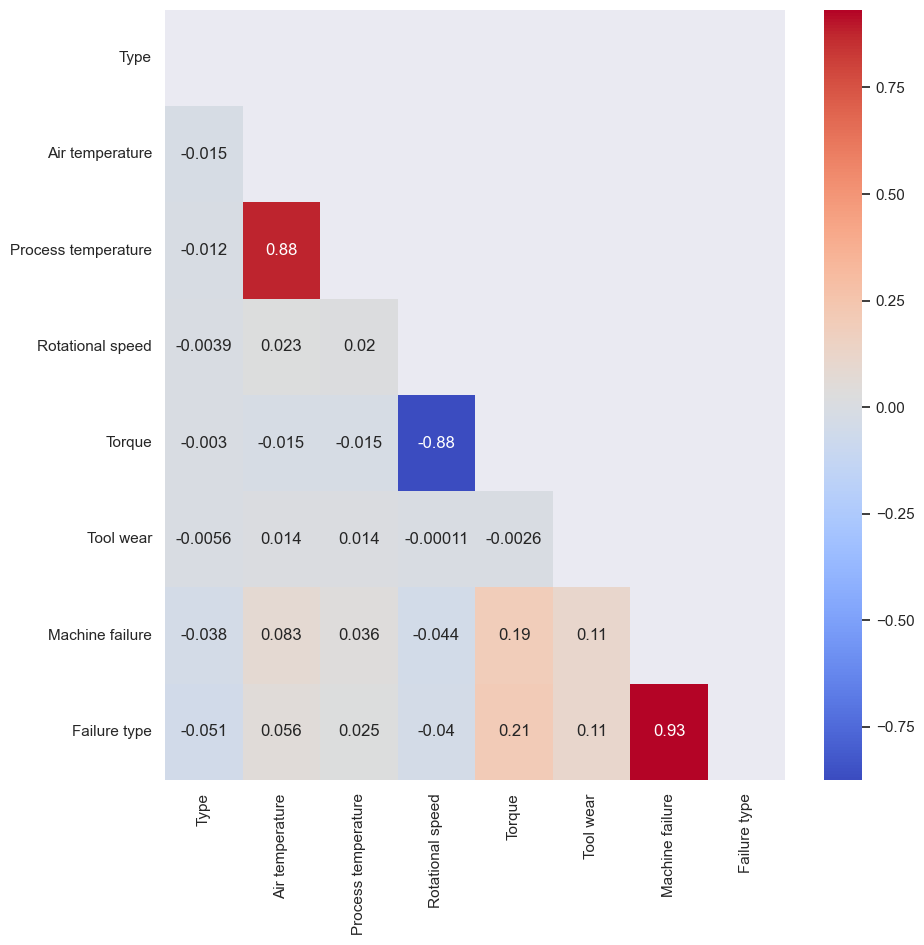

In [26]:
# heatmap for correlation of the features

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cbar=True, mask=np.triu(df.corr()),annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='Tool wear', ylabel='Density'>

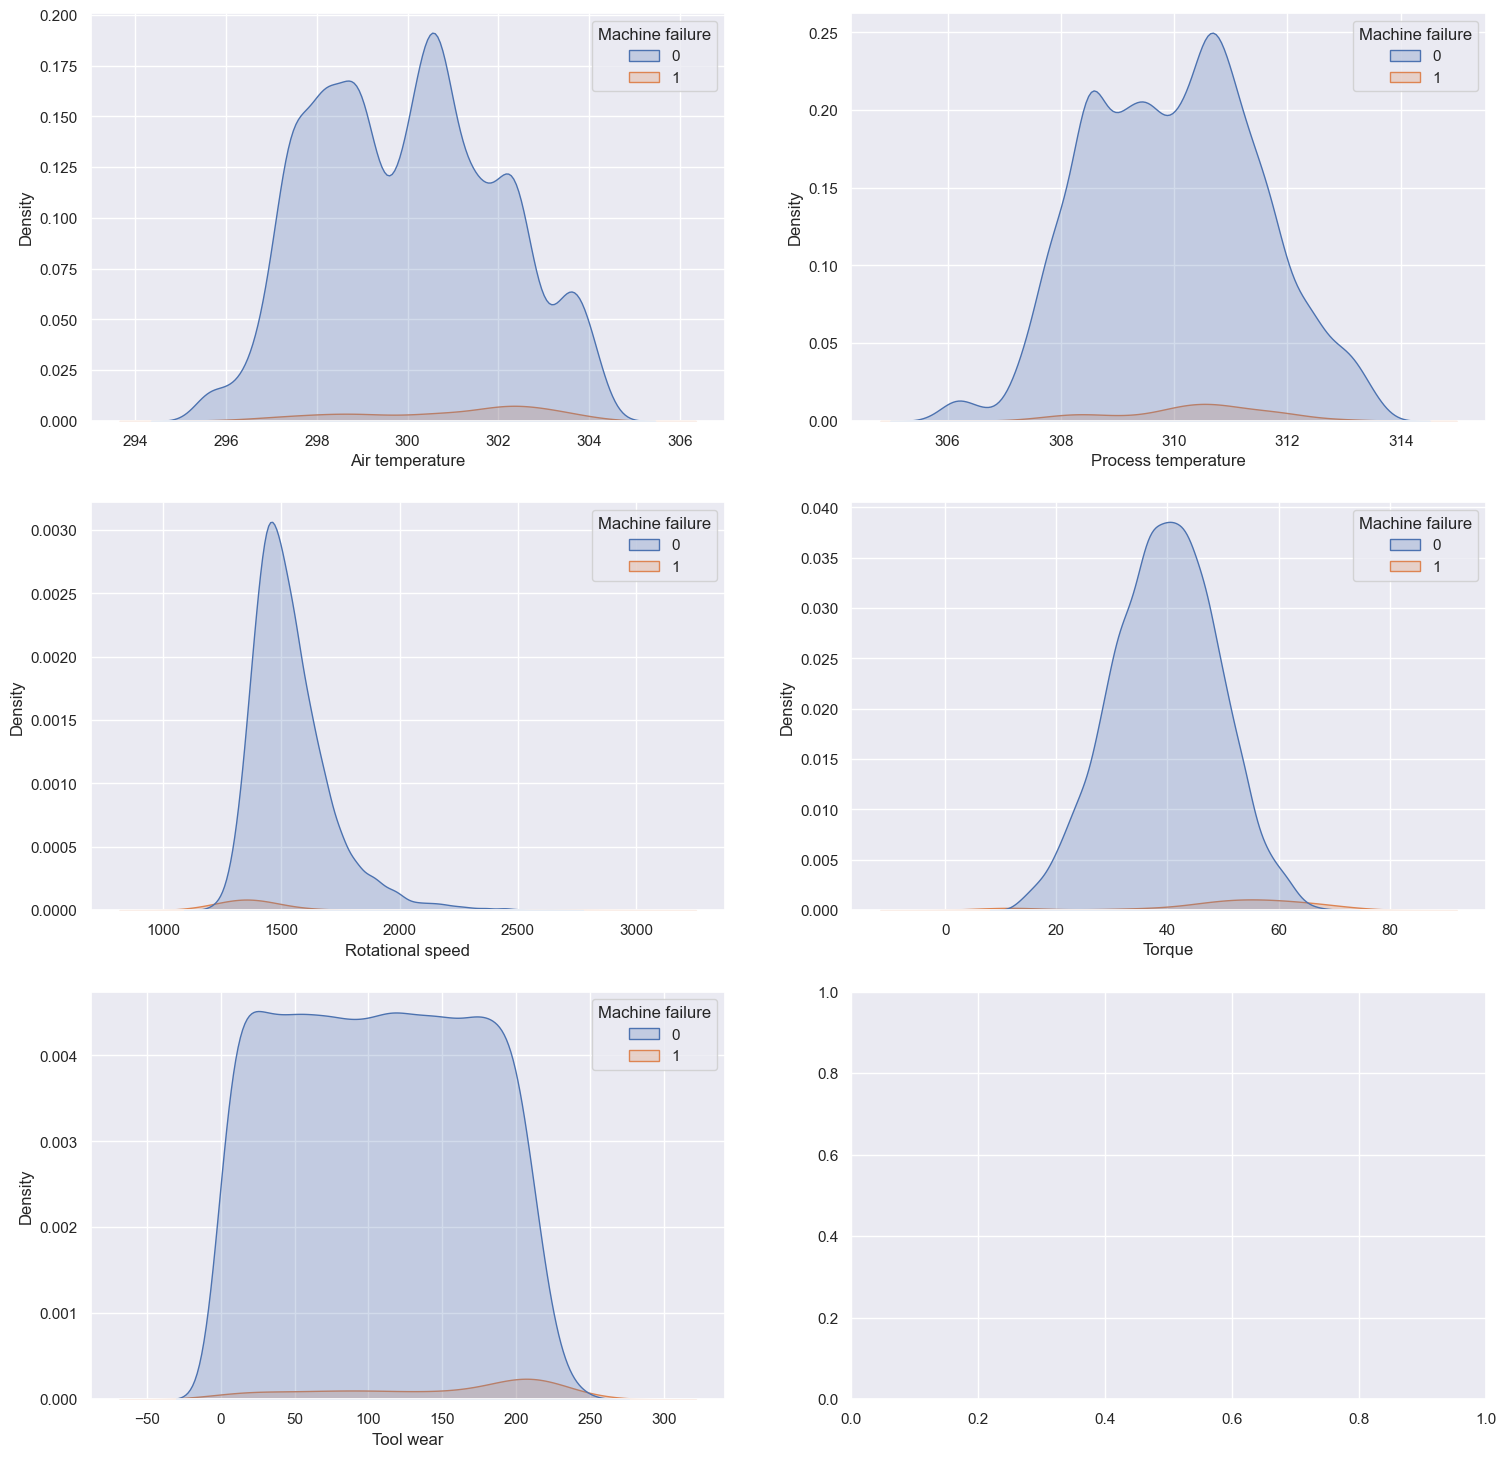

In [27]:
# KDEplot Kernel Density Estimate - PDF

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

sns.kdeplot(data=df, x=df['Air temperature'], ax=axs[0, 0], fill=True, hue='Machine failure')
sns.kdeplot(data=df,x=df['Process temperature'], ax=axs[0, 1], fill=True, hue='Machine failure')
sns.kdeplot(data=df,x=df['Rotational speed'], ax=axs[1, 0], fill=True, hue='Machine failure')
sns.kdeplot(data=df,x=df['Torque'], ax=axs[1, 1], fill=True, hue='Machine failure')
sns.kdeplot(data=df,x=df['Tool wear'], ax=axs[2, 0], fill=True, hue='Machine failure')

<AxesSubplot:xlabel='Tool wear', ylabel='Density'>

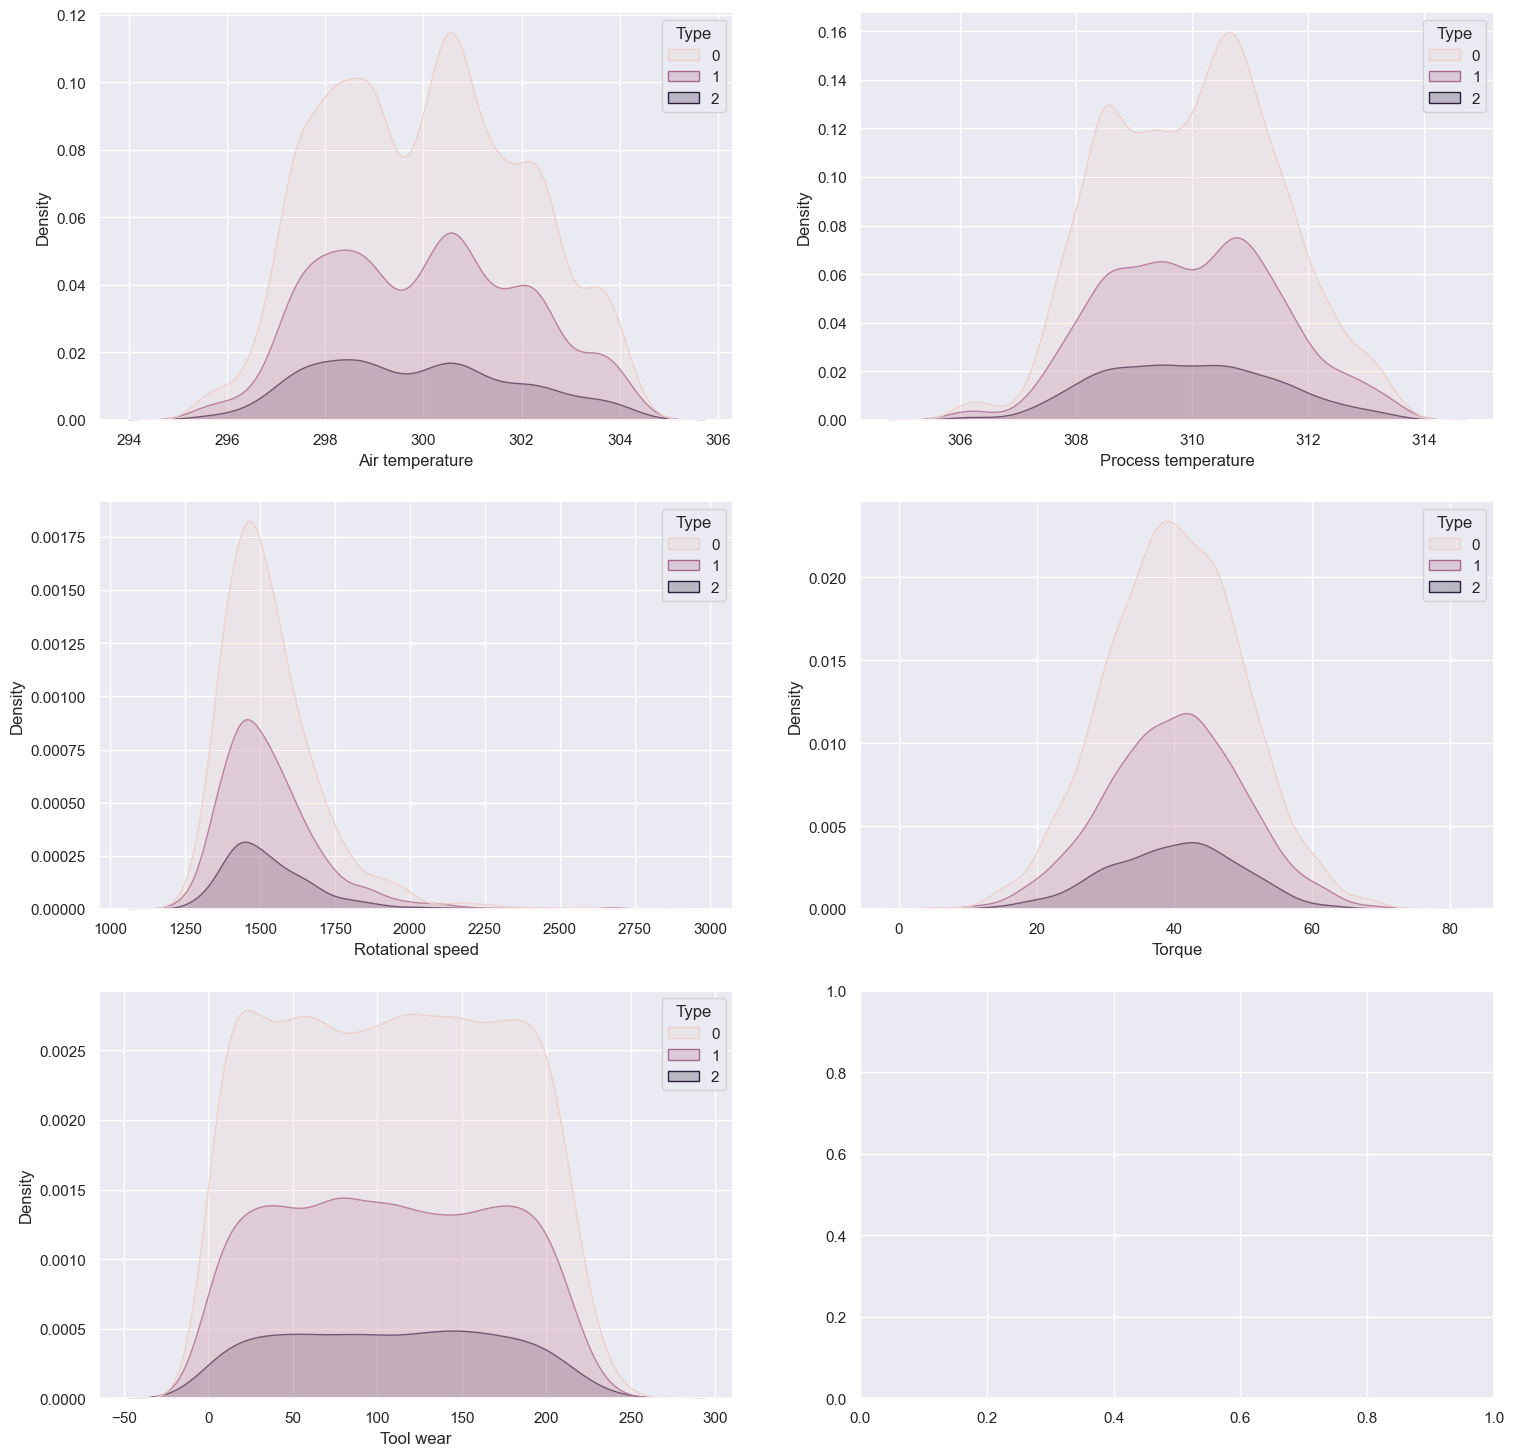

In [28]:
# KDEplot 

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

sns.kdeplot(data=df, x=df['Air temperature'], ax=axs[0, 0], fill=True, hue='Type')
sns.kdeplot(data=df,x=df['Process temperature'], ax=axs[0, 1], fill=True, hue='Type')
sns.kdeplot(data=df,x=df['Rotational speed'], ax=axs[1, 0], fill=True, hue='Type')
sns.kdeplot(data=df,x=df['Torque'], ax=axs[1, 1], fill=True, hue='Type')
sns.kdeplot(data=df,x=df['Tool wear'], ax=axs[2, 0], fill=True, hue='Type')

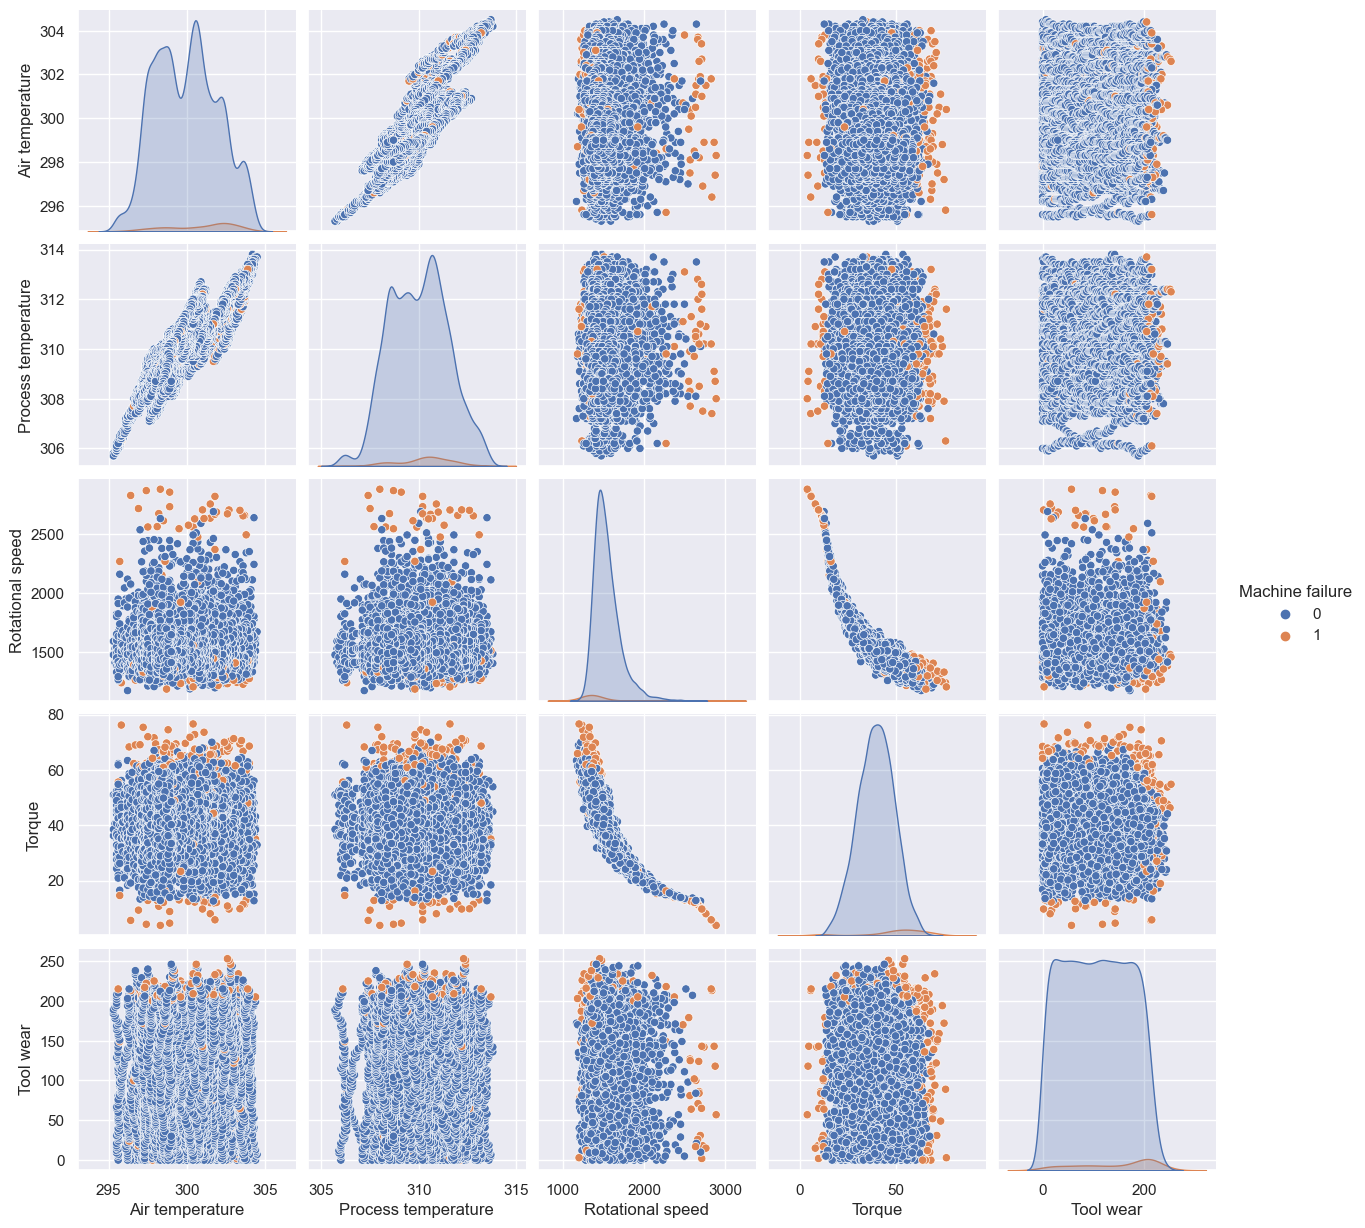

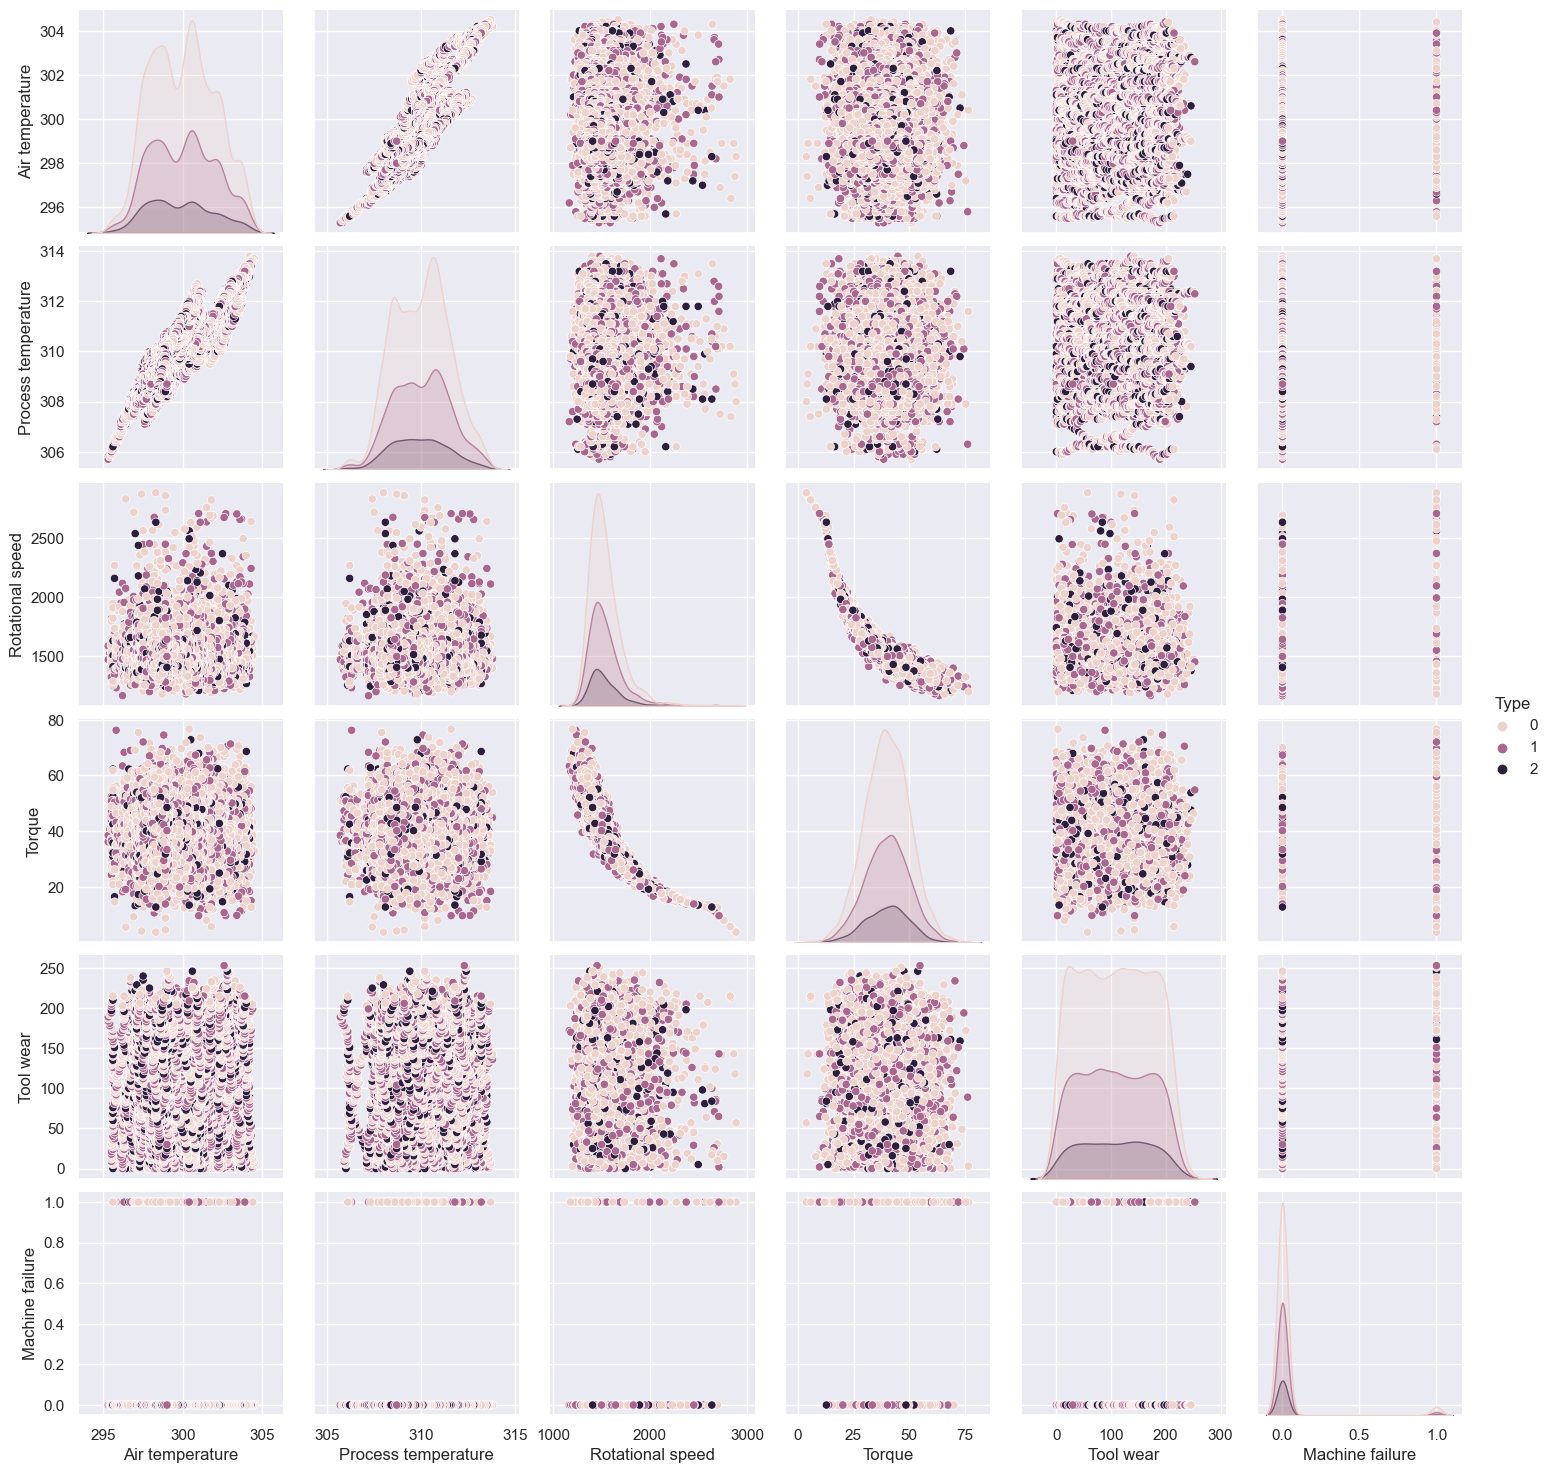

In [29]:
sns.pairplot(df,
             x_vars=['Air temperature','Process temperature','Rotational speed','Torque','Tool wear'],
             y_vars=['Air temperature','Process temperature','Rotational speed','Torque','Tool wear'],
             hue='Machine failure')

sns.pairplot(df,
             x_vars=['Air temperature','Process temperature','Rotational speed','Torque','Tool wear','Machine failure'],
             y_vars=['Air temperature','Process temperature','Rotational speed','Torque','Tool wear','Machine failure'],
             hue='Type')



1) Torque and Rotational speed are observed to be highly inversely correlated.
2) Process temperature and Air temperature are highly correlated.

<AxesSubplot:xlabel='Machine failure', ylabel='Torque'>

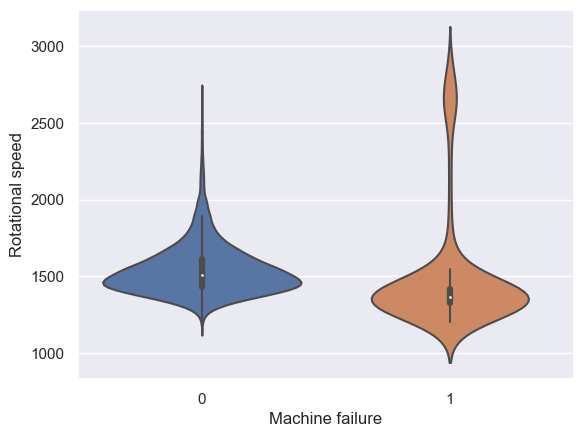

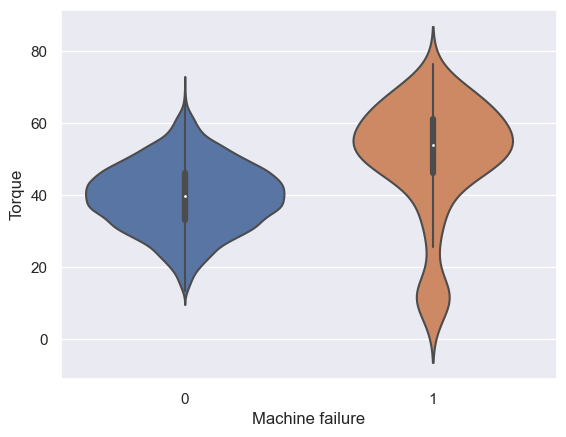

In [30]:
# violin plot - kernel density plot shows peaks in the data

sns.violinplot(data=df, x='Machine failure', y='Rotational speed')

plt.figure()

sns.violinplot(data=df, x='Machine failure', y='Torque')


<AxesSubplot:xlabel='Type', ylabel='Torque'>

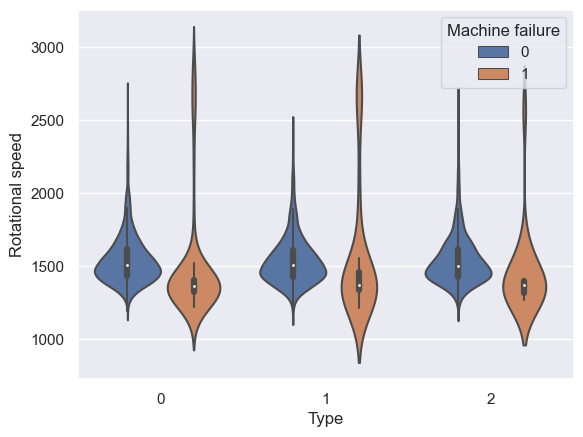

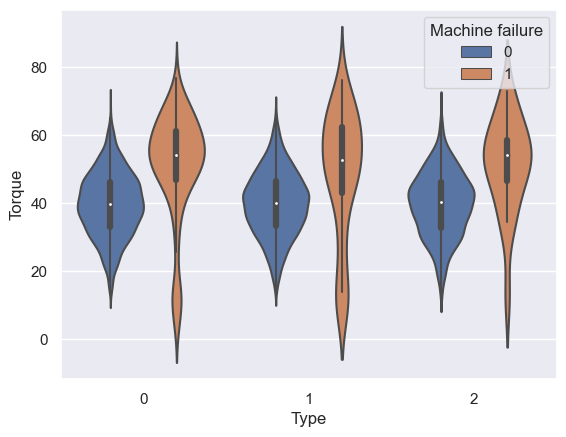

In [31]:
sns.violinplot(data=df, x='Type', y='Rotational speed',hue='Machine failure')

plt.figure()

sns.violinplot(data=df, x='Type', y='Torque',hue='Machine failure')

In [32]:
# Feature engineering

# Consider only Process temperature as Air and Process temperatures are strongly correlated
# Power as Torque and Rotational speed are strongly inversely correlated
# Strain as Torque and Tool wear product for OSF 

df['Power'] = df['Torque'] * df['Rotational speed']
df['Resultant temperature'] = df['Process temperature'] - df['Air temperature']
df['Strain'] = df['Torque'] * df['Tool wear']

<AxesSubplot:>

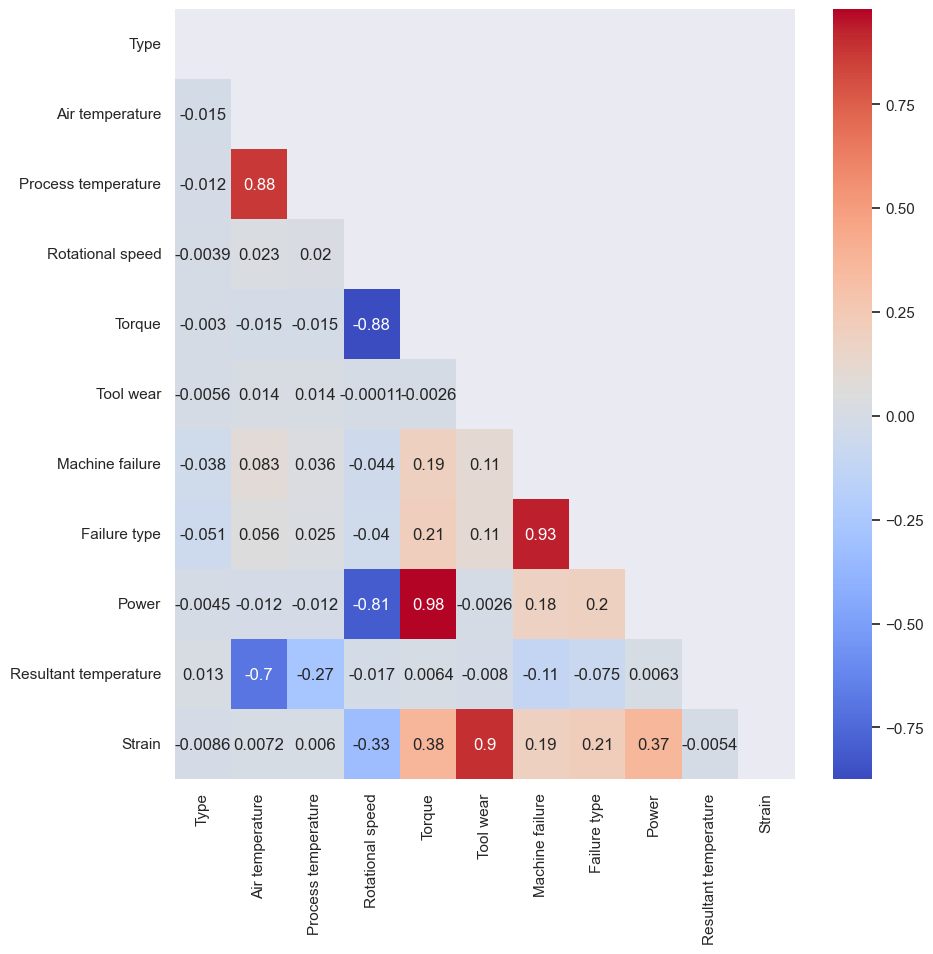

In [33]:
# heatmap for correlation of the features

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cbar=True, mask=np.triu(df.corr()),annot=True, cmap='coolwarm')

In [34]:
print(df['Air temperature'].min())
print(df['Air temperature'].max())

print(df['Process temperature'].min())
print(df['Process temperature'].max())

print(df['Tool wear'].min())
print(df['Tool wear'].max())

# Low tool wear 

295.3
304.5
305.7
313.8
0.0
253.0


## 3.5 Feature Selection using PCA, Chi2, ANOVA, Mutual Information and Kendall's Tau

In [35]:
features = ['Type',  'Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']

In [36]:
# PCA

from sklearn.decomposition import PCA

pca= PCA(n_components=len(features))
pca.fit(df[features])

#print("Components", pca.components_)
print("Explained Variance",pca.explained_variance_)
print("Explained Variance Ratio",pca.explained_variance_ratio_)

Explained Variance [3.22648521e+04 4.05121641e+03 2.32154430e+01 5.84857599e+00
 4.50029050e-01 3.49824694e-01]
Explained Variance Ratio [8.87715625e-01 1.11462718e-01 6.38735658e-04 1.60914183e-04
 1.23818271e-05 9.62486504e-06]


In [37]:
# chi2

from sklearn.feature_selection import SelectKBest, chi2, f_classif

best_features = SelectKBest(score_func=chi2,k='all')

X = df.iloc[:,:-5]
y = df['Machine failure']
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=False,inplace=True)


feature_score

feature        score
5            Tool wear  4232.790513
4               Torque   926.967640
3     Rotational speed   404.582031
0                 Type    13.271322
1      Air temperature     0.917914
2  Process temperature     0.091758

# ANOVA f_classify

Performing Feature Selection with Numerical Input Data and Categorical Output Data - ANOVA f-test statistic and mutual information statistic

In [38]:
X = df.loc[:, ['Type','Air temperature','Process temperature','Torque','Rotational speed','Tool wear']]
y = df['Machine failure']

X_f = df.loc[:, ['Type','Strain','Power','Resultant temperature']]
y_f = df['Machine failure']


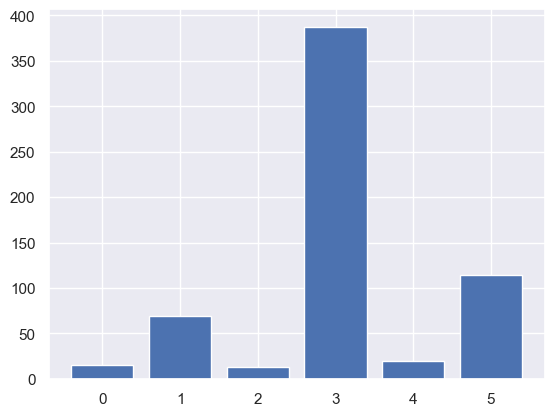

feature_ANOVA  score_ANOVA
3               Torque   387.525409
5            Tool wear   114.036280
1      Air temperature    69.277767
4     Rotational speed    19.378088
0                 Type    14.761658
2  Process temperature    12.937264

In [39]:
best_features_ANOVA = SelectKBest(score_func=f_classif,k='all')

fit = best_features_ANOVA.fit(X,y)

df_scores_ANOVA=pd.DataFrame(fit.scores_)
df_col_ANOVA=pd.DataFrame(X.columns)

feature_score_ANOVA=pd.concat([df_col_ANOVA,df_scores_ANOVA],axis=1)
feature_score_ANOVA.columns=['feature_ANOVA','score_ANOVA']
feature_score_ANOVA.sort_values(by=['score_ANOVA'],ascending=False,inplace=True)

plt.bar([i for i in range(len(fit.scores_))], fit.scores_)
plt.show()

feature_score_ANOVA

# Mutual information feature selection

source paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3929353/

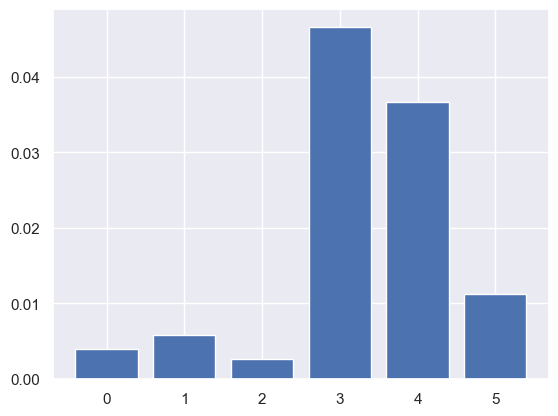

feature_Mutual  score_Mutual
3               Torque      0.046654
4     Rotational speed      0.036741
5            Tool wear      0.011273
1      Air temperature      0.005865
0                 Type      0.003986
2  Process temperature      0.002652

In [40]:
from sklearn.feature_selection import mutual_info_classif

best_features_Mutual = SelectKBest(score_func=mutual_info_classif,k='all')

fit = best_features_Mutual.fit(X,y)

df_scores_Mutual=pd.DataFrame(fit.scores_)
df_col_Mutual=pd.DataFrame(X.columns)

feature_score_Mutual=pd.concat([df_col_Mutual,df_scores_Mutual],axis=1)
feature_score_Mutual.columns=['feature_Mutual','score_Mutual']
feature_score_Mutual.sort_values(by=['score_Mutual'],ascending=False,inplace=True)

plt.bar([i for i in range(len(fit.scores_))], fit.scores_)
plt.show()

feature_score_Mutual

# Kendalls Tau scipy.stats.kendalltau

In [41]:
from scipy.stats import kendalltau

coef, p = kendalltau(X.iloc[:,0],y)

coef

-0.03765157555508181

In [42]:
p

9.94603903439945e-05

In [43]:
feature_score_Kendalltau=[]
for column in X:
    coef, p = kendalltau(X[column], y)
    feature_score_Kendalltau.append((column, coef, p))
    
feature_score_Kendalltau

[('Type', -0.03765157555508181, 9.94603903439945e-05),
 ('Air temperature', 0.06895785596520101, 5.672330465428692e-17),
 ('Process temperature', 0.03294936968503267, 6.555128284329079e-05),
 ('Torque', 0.13966270101821376, 3.1398169959346447e-65),
 ('Rotational speed', -0.13786593341303652, 1.1761932248550323e-63),
 ('Tool wear', 0.08380597830006203, 1.5139200976930913e-24)]

In [44]:
kendalltau_coef = pd.DataFrame(feature_score_Kendalltau, columns=['Feature','Coefficient','Pscores'])

kendalltau_coef.sort_values(by='Coefficient',ascending=False,inplace=True)

print(kendalltau_coef)

               Feature  Coefficient       Pscores
3               Torque     0.139663  3.139817e-65
5            Tool wear     0.083806  1.513920e-24
1      Air temperature     0.068958  5.672330e-17
2  Process temperature     0.032949  6.555128e-05
0                 Type    -0.037652  9.946039e-05
4     Rotational speed    -0.137866  1.176193e-63


## 4. **Binary Classification** <a id="binary"></a> 

The Binary Classification models predict weather the operation data points result in a machine failure or not. Dataset is split into train and test with 80:20 ratio with stratification. Classification algorithms used here are -
1. Logistic Regression - Estimates the probability of a label as a function of its features.
2. Decision Tree Classifier
3. Random Forest Classifier
4. XGBoost Classifier


In [45]:
# split dataset into train and test

# dataset with all existing features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

# dataset with engineered features
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.2, stratify = y_f, random_state=0)

In [46]:
# creating a dataframe to hold different model performances

model_performance = pd.DataFrame(columns=['Accuracy', 
                                          'Precision',
                                          'Recall', 
                                          'F1-Score', 
                                          'MCC',
                                          'ROC_AUC',
                                          'Training_Time',
                                          'Prediction_Time'])

In [47]:
# creating a method to compute the performance metrics
def model_scores(mode, name, model, y_test, y_pred, X_test, start_time, train_time, predict_time):
    if mode == 'bi':
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1score = f1_score(y_test, y_pred, average='weighted')
        MCC = matthews_corrcoef(y_test, y_pred)
        ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

        print("Accuracy: "+ "{:.2%}".format(accuracy))
        print("Recall: "+ "{:.2%}".format(recall))
        print("Precision: "+ "{:.2%}".format(precision))
        print("F1-Score: "+ "{:.2%}".format(f1score))
        print("MCC: "+ "{:.2%}".format(MCC))
        print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
        print("time to train: "+ "{:.5f}".format(train_time-start_time)+" s")
        print("time to predict: "+"{:.5f}".format(predict_time-train_time)+" s")
        print("total: "+"{:.5f}".format(predict_time-start_time)+" s")
        print("start time: "+ "{:.5f}".format(start_time)+" s")
        print("train time: "+ "{:.5f}".format(train_time)+" s")
        print("predict time: "+ "{:.5f}".format(predict_time)+" s")

        plot_confusion_matrix(model, X_test, y_test, cmap='Blues')

        model_performance.loc[name] = [accuracy, recall, precision, f1score, MCC, ROC_AUC, train_time-start_time, predict_time-train_time]
        
    elif mode == 'mul':
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1score = f1_score(y_test, y_pred, average='weighted')
        MCC = matthews_corrcoef(y_test, y_pred)
        #ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

        print("Accuracy: "+ "{:.2%}".format(accuracy))
        print("Recall: "+ "{:.2%}".format(recall))
        print("Precision: "+ "{:.2%}".format(precision))
        print("F1-Score: "+ "{:.2%}".format(f1score))
        print("MCC: "+ "{:.2%}".format(MCC))
        #print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
        print("time to train: "+ "{:.5f}".format(train_time-start_time)+" s")
        print("time to predict: "+"{:.5f}".format(predict_time-train_time)+" s")
        print("total: "+"{:.5f}".format(predict_time-start_time)+" s")
        print("start time: "+ "{:.5f}".format(start_time)+" s")
        print("train time: "+ "{:.5f}".format(train_time)+" s")
        print("predict time: "+ "{:.5f}".format(predict_time)+" s")

        plot_confusion_matrix(model, X_test, y_test, cmap='Blues')

        model_performance.loc[name] = [accuracy, recall, precision, f1score, MCC, 'NA', train_time-start_time, predict_time-train_time]


Accuracy: 97.14%
Recall: 97.14%
Precision: 96.70%
F1-Score: 96.26%
MCC: 37.32%
ROC AUC score: 91.13%
time to train: 0.14439 s
time to predict: 0.01567 s
total: 0.16007 s
start time: 1681674667.52010 s
train time: 1681674667.66450 s
predict time: 1681674667.68017 s


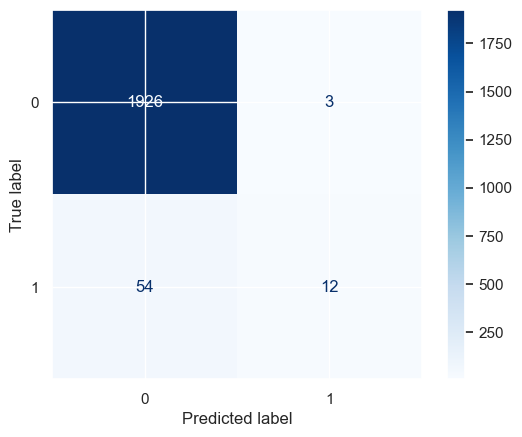

In [48]:
# Linear Algorithm
# Logistic Regression with all features

start_time = time.time()
model = LogisticRegression().fit(X_train, y_train)
train_time = time.time()

predict_LR = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_LR', model, y_test, predict_LR, X_test, start_time, train_time, predict_time)

Accuracy: 96.79%
Recall: 96.79%
Precision: 96.89%
F1-Score: 95.31%
MCC: 17.13%
ROC AUC score: 81.76%
time to train: 0.05821 s
time to predict: 0.00312 s
total: 0.06133 s
start time: 1681674671.04019 s
train time: 1681674671.09840 s
predict time: 1681674671.10152 s


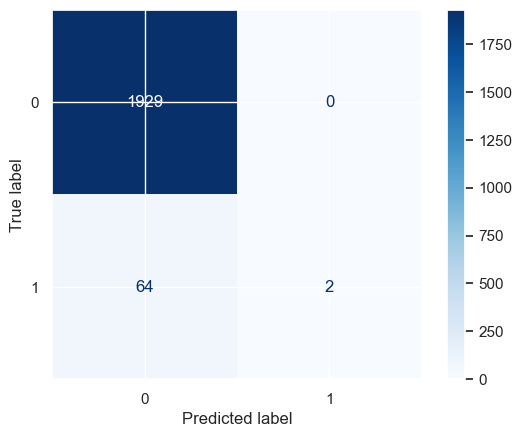

In [49]:
# Logistic Regression with engineered features

start_time = time.time()
model = LogisticRegression().fit(X_f_train, y_f_train)
train_time = time.time()

predict_LR = model.predict(X_f_test)
predict_time = time.time()

model_scores('bi','bi_LR_f', model, y_f_test, predict_LR, X_f_test, start_time, train_time, predict_time)

In [50]:
# cost sensitive algorithm - assigning weights to classes
# gridsearch method

#grid
cost = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
grid_param = dict(class_weight = cost)

# evaluation
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
model = LogisticRegression()
#grid search
grid = GridSearchCV(estimator = model, param_grid = grid_param, n_jobs = -1, cv = cv, scoring = 'recall')
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("The best estimator across searched params: ",grid_result.best_estimator_)
print("\n The best score across searched params: ",grid_result.best_score_)
print("\n The best parameters across searched params: ",grid_result.best_params_)

The best estimator across searched params:  LogisticRegression(class_weight={0: 1, 1: 100})

 The best score across searched params:  0.9495726495726496

 The best parameters across searched params:  {'class_weight': {0: 1, 1: 100}}


Accuracy: 62.81%
Recall: 62.81%
Precision: 96.62%
F1-Score: 74.20%
MCC: 20.32%
ROC AUC score: 91.11%
time to train: 0.07175 s
time to predict: 0.00833 s
total: 0.08008 s
start time: 1681674685.78783 s
train time: 1681674685.85957 s
predict time: 1681674685.86791 s


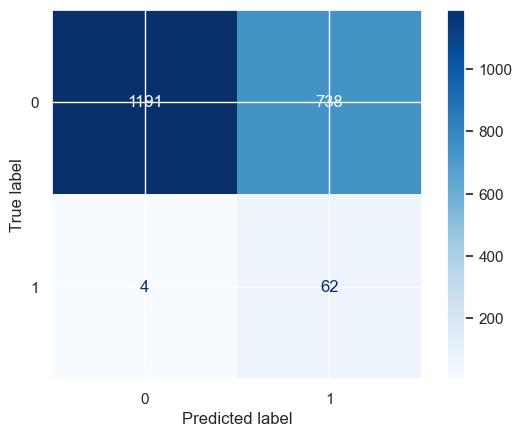

In [51]:
# Logistic Regression with Hyperparameters

class_weight = {0:1,1:100}

start_time = time.time()
model = LogisticRegression(class_weight = {0:1,1:100}).fit(X_train, y_train)
train_time = time.time()

predict_LR = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_LR_Hyp', model, y_test, predict_LR, X_test, start_time, train_time, predict_time)

Accuracy: 98.05%
Recall: 98.05%
Precision: 97.98%
F1-Score: 98.01%
MCC: 68.34%
ROC AUC score: 82.89%
time to train: 0.03742 s
time to predict: 0.00551 s
total: 0.04293 s
start time: 1681674690.87615 s
train time: 1681674690.91357 s
predict time: 1681674690.91908 s


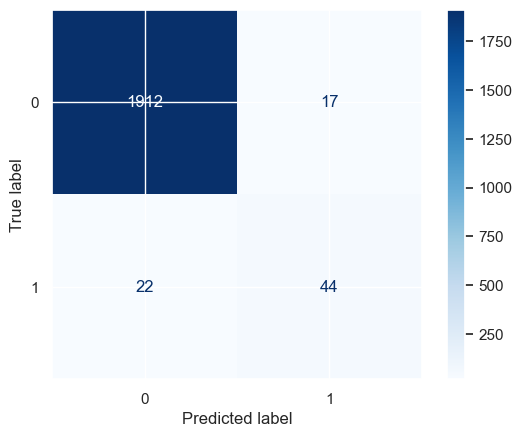

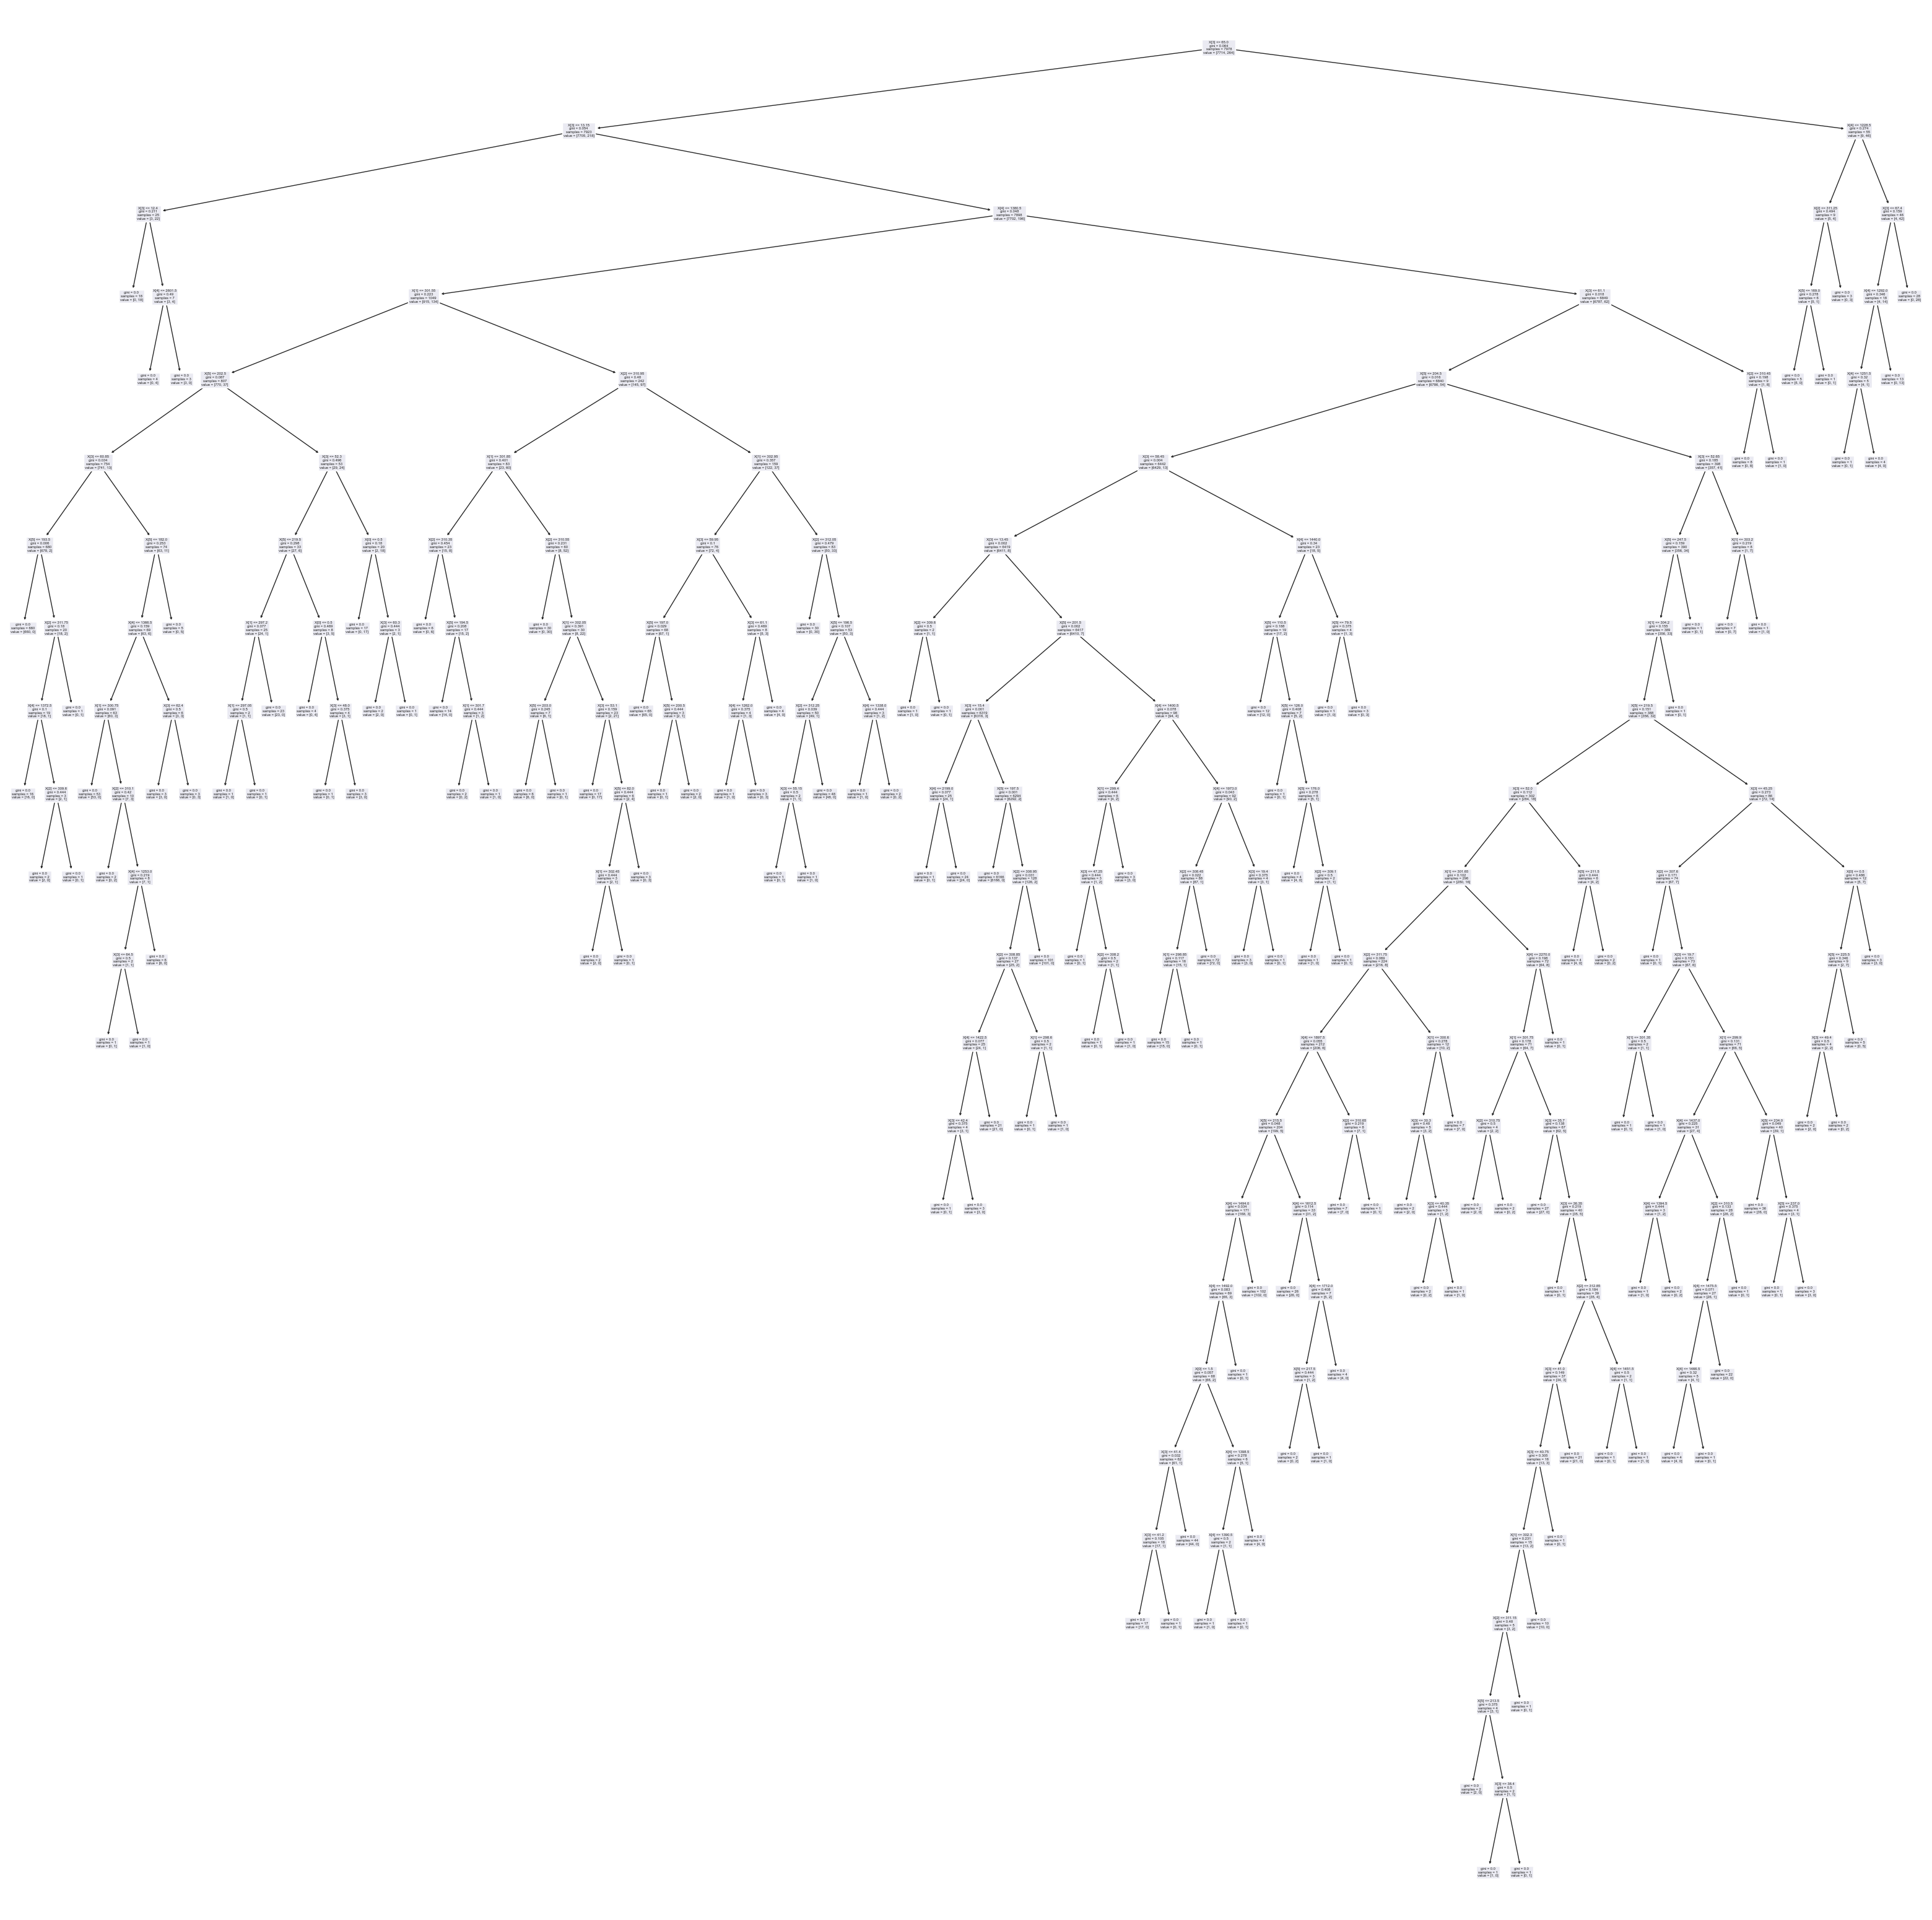

In [52]:
# Non-linear Algorithm
# Decision Tree Classifier with all features

start_time = time.time()
model = DecisionTreeClassifier().fit(X_train, y_train)
train_time = time.time()

predict_DT = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_DT', model, y_test, predict_DT, X_test, start_time, train_time, predict_time)
fig = plt.figure(figsize=(40,40))
tree.plot_tree(model)
plt.show()


Accuracy: 97.74%
Recall: 97.74%
Precision: 97.76%
F1-Score: 97.75%
MCC: 65.00%
ROC AUC score: 82.74%
time to train: 0.01562 s
time to predict: 0.01562 s
total: 0.03124 s
start time: 1681674833.11230 s
train time: 1681674833.12792 s
predict time: 1681674833.14354 s


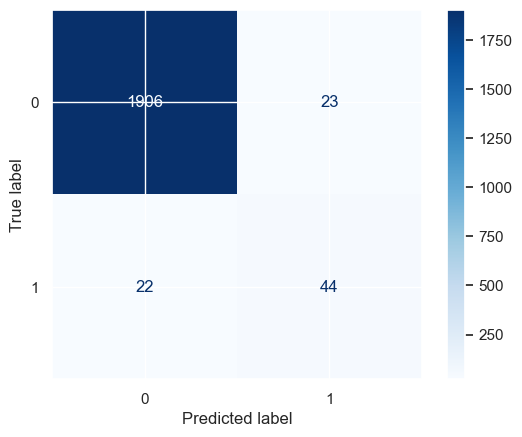

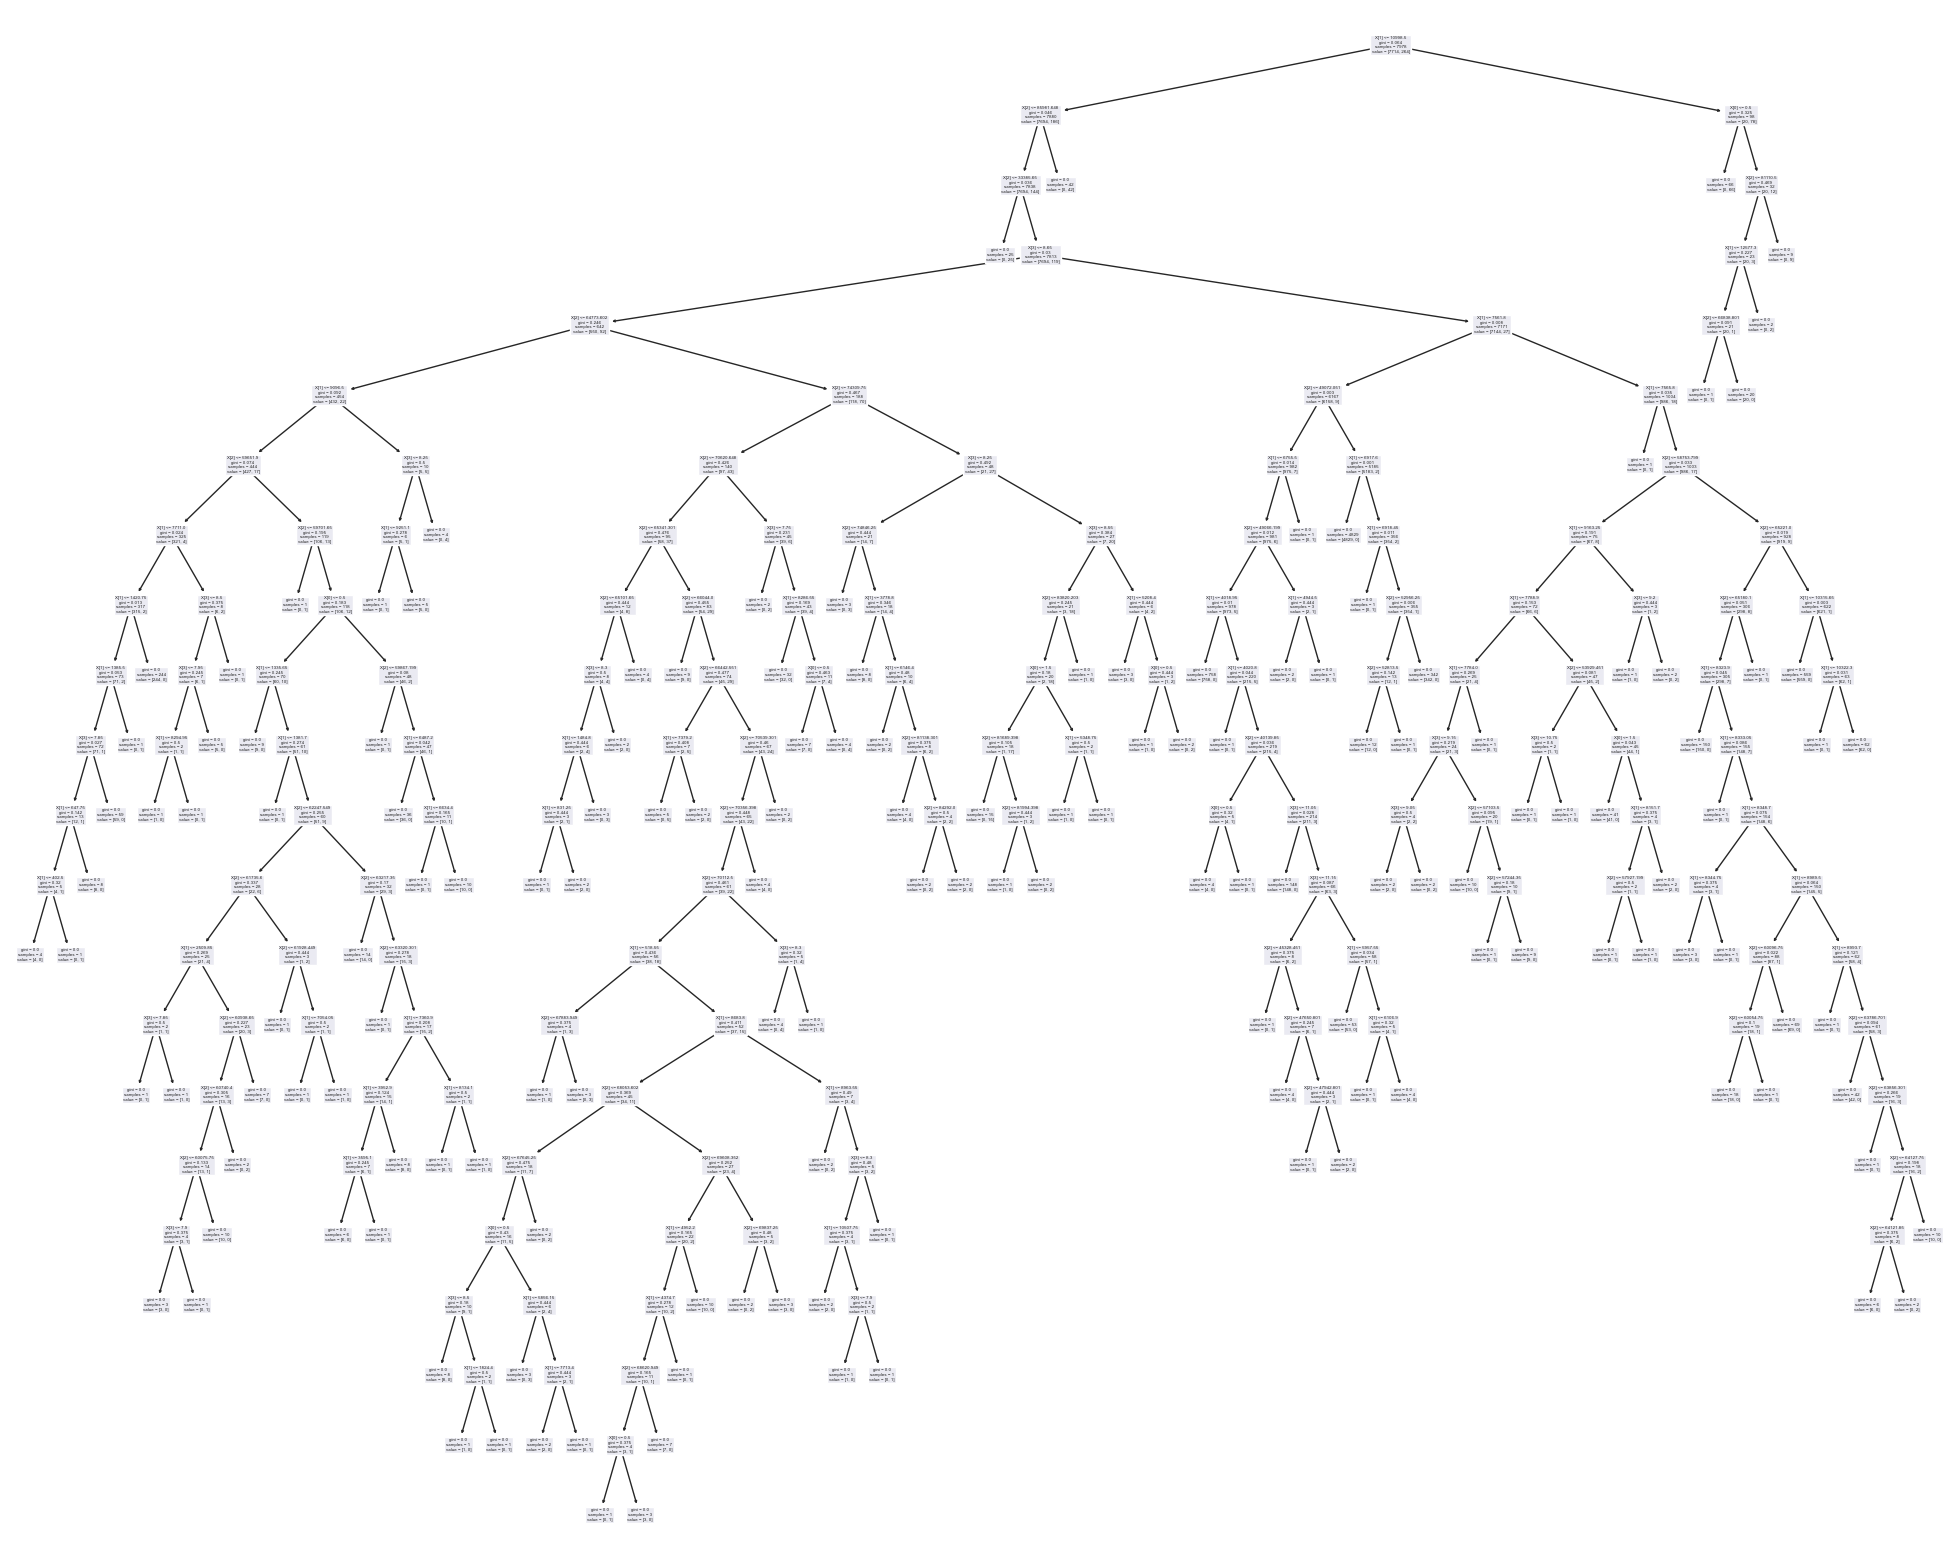

In [54]:
# Decision Tree Classifier with engineered features

start_time = time.time()
model = DecisionTreeClassifier().fit(X_f_train, y_f_train)
train_time = time.time()

predict_DT = model.predict(X_f_test)
predict_time = time.time()

model_scores('bi','bi_DT_f', model, y_f_test, predict_DT, X_f_test, start_time, train_time, predict_time)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model)
plt.show()

In [55]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [56]:
# Hyperparameter search for Decision Tree Classifier

dtc_params = {'min_samples_leaf': [5, 10, 20, 50, 100], 'max_depth':[5,7,10], 'criterion': ['gini', 'entropy'], 'random_state':[0]}
 
    
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator = model, param_grid = dtc_params, n_jobs = -1, cv = cv, scoring = 'recall')
grid_result = grid.fit(X_train, y_train)

print("The best estimator across searched params: ",grid_result.best_estimator_)
print("\n The best score across searched params: ",grid_result.best_score_)
print("\n The best parameters across searched params: ",grid_result.best_params_)


The best estimator across searched params:  DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=0)

 The best score across searched params:  0.6770180436847103

 The best parameters across searched params:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'random_state': 0}


Accuracy: 98.40%
Recall: 98.40%
Precision: 98.28%
F1-Score: 98.26%
MCC: 71.85%
ROC AUC score: 91.84%
time to train: 0.03128 s
time to predict: 0.00000 s
total: 0.03128 s
start time: 1681674855.32789 s
train time: 1681674855.35916 s
predict time: 1681674855.35916 s


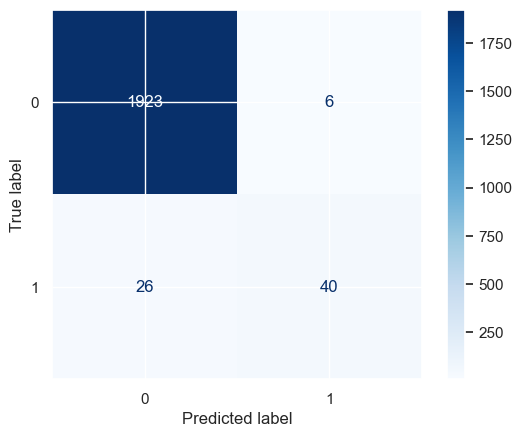

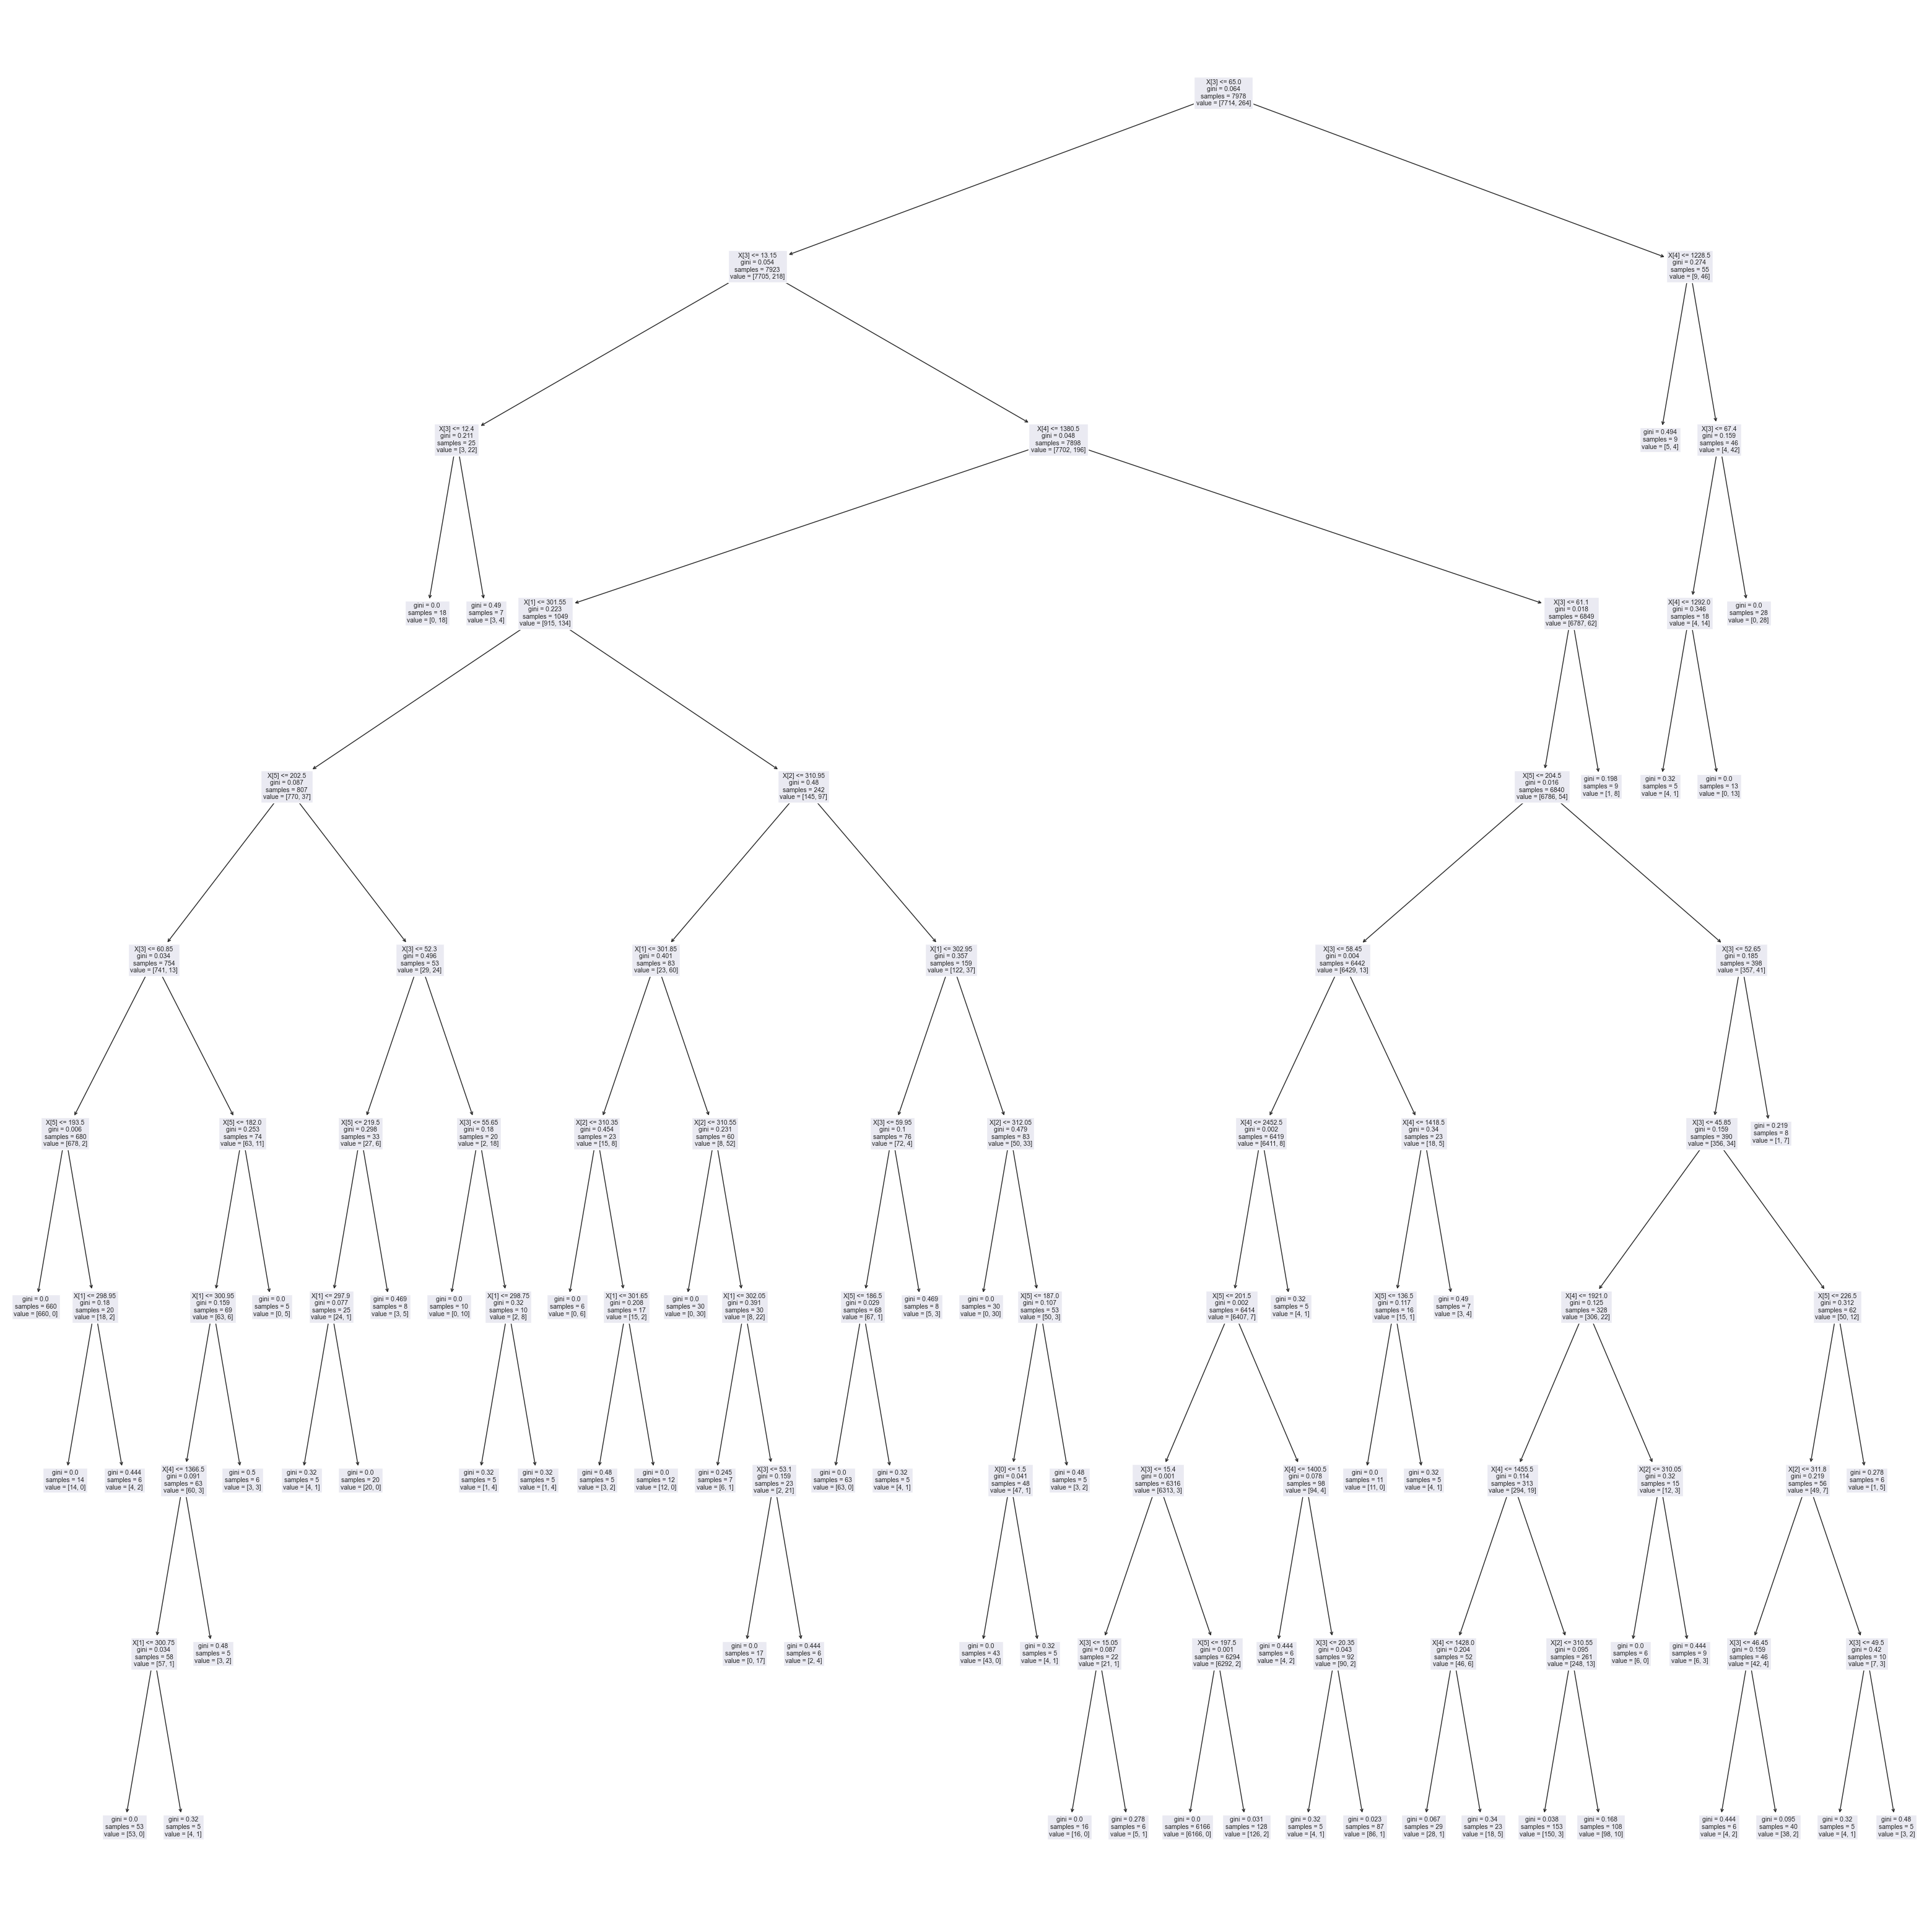

In [57]:
# Decision Tree Classifier with Hyperparameters
# 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'random_state': 0
start_time = time.time()
model = DecisionTreeClassifier(criterion='gini', max_depth= 10, min_samples_leaf= 5, random_state= 0).fit(X_train, y_train)
train_time = time.time()

predict_DT = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_DT_Hyp', model, y_test, predict_DT, X_test, start_time, train_time, predict_time)
fig = plt.figure(figsize=(40,40))
tree.plot_tree(model)
plt.show()

Accuracy: 98.20%
Recall: 98.20%
Precision: 98.05%
F1-Score: 97.98%
MCC: 67.33%
ROC AUC score: 96.91%
time to train: 0.66546 s
time to predict: 0.02048 s
total: 0.68594 s
start time: 1681674867.89569 s
train time: 1681674868.56115 s
predict time: 1681674868.58163 s
Accuracy: 98.45%
Recall: 98.45%
Precision: 98.33%
F1-Score: 98.33%
MCC: 73.11%
ROC AUC score: 94.27%
time to train: 0.63422 s
time to predict: 0.02041 s
total: 0.65464 s
start time: 1681674868.65332 s
train time: 1681674869.28755 s
predict time: 1681674869.30796 s


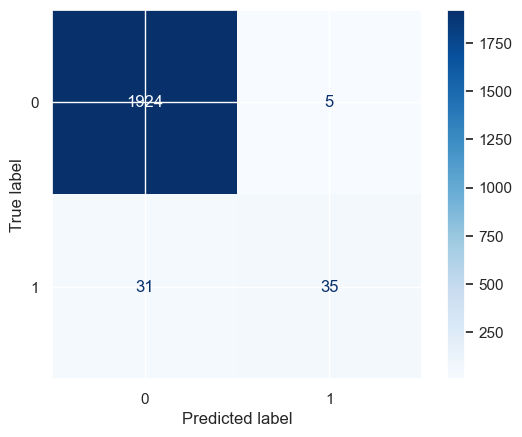

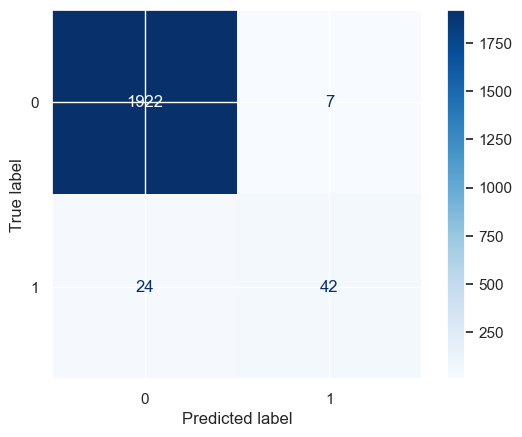

In [58]:
#Ensemble Algorithm
# Random Forest Classifier with all features

start_time = time.time()
model = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
train_time = time.time()

predict_RF = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_RF', model, y_test, predict_RF, X_test, start_time, train_time, predict_time)


# Random Forest Classifier with engineered features

start_time = time.time()
model = RandomForestClassifier(n_estimators = 100).fit(X_f_train, y_f_train)
train_time = time.time()

predict_RF = model.predict(X_f_test)
predict_time = time.time()

model_scores('bi','bi_RF_f', model, y_f_test, predict_RF, X_f_test, start_time, train_time, predict_time)

In [59]:
# Hyperparameter search for Random Forest Classifier

rfc_params = {'n_estimators':[100,300,500,700], 'max_depth':[5,7,10], 'random_state':[0]}


model = RandomForestClassifier()
grid = GridSearchCV(estimator = model, param_grid = rfc_params, n_jobs = -1, cv = cv, scoring = 'recall')
grid_result = grid.fit(X_train, y_train)

print("The best estimator across searched params: ",grid_result.best_estimator_)
print("\n The best score across searched params: ",grid_result.best_score_)
print("\n The best parameters across searched params: ",grid_result.best_params_)

The best estimator across searched params:  RandomForestClassifier(max_depth=10, random_state=0)

 The best score across searched params:  0.6141025641025641

 The best parameters across searched params:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 0}


Accuracy: 98.15%
Recall: 98.15%
Precision: 97.99%
F1-Score: 97.91%
MCC: 66.22%
ROC AUC score: 98.35%
time to train: 0.48190 s
time to predict: 0.02049 s
total: 0.50238 s
start time: 1681674983.22520 s
train time: 1681674983.70710 s
predict time: 1681674983.72759 s


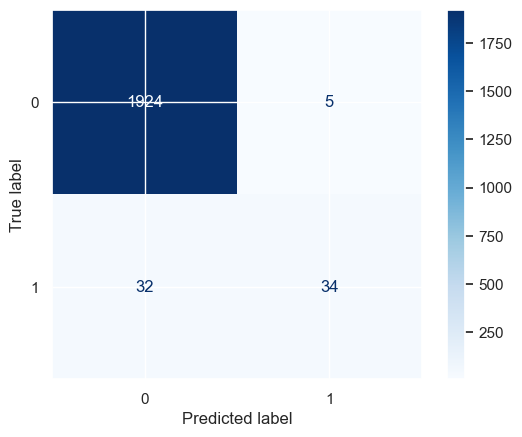

In [60]:
# Random Forest Classifier with Hyperparameters
# 'max_depth': 10, 'n_estimators': 100, 'random_state': 0
start_time = time.time()
model = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 0).fit(X_train, y_train)
train_time = time.time()

predict_RF = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_RF_Hyp', model, y_test, predict_RF, X_test, start_time, train_time, predict_time)


Accuracy: 98.20%
Recall: 98.20%
Precision: 98.04%
F1-Score: 98.04%
MCC: 68.12%
ROC AUC score: 97.88%
time to train: 0.65899 s
time to predict: 0.00813 s
total: 0.66712 s
start time: 1681674987.59525 s
train time: 1681674988.25423 s
predict time: 1681674988.26237 s
Accuracy: 98.55%
Recall: 98.55%
Precision: 98.46%
F1-Score: 98.43%
MCC: 74.74%
ROC AUC score: 96.51%
time to train: 0.56698 s
time to predict: 0.00804 s
total: 0.57502 s
start time: 1681674988.29478 s
train time: 1681674988.86175 s
predict time: 1681674988.86979 s


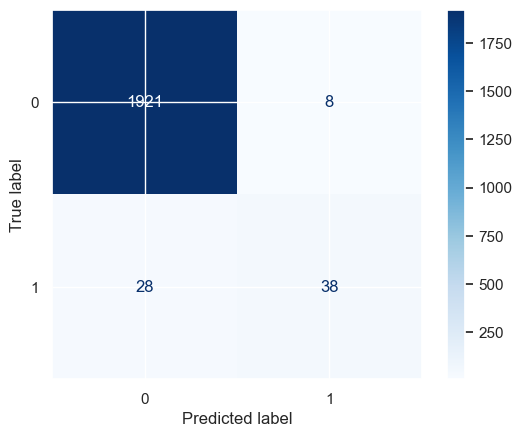

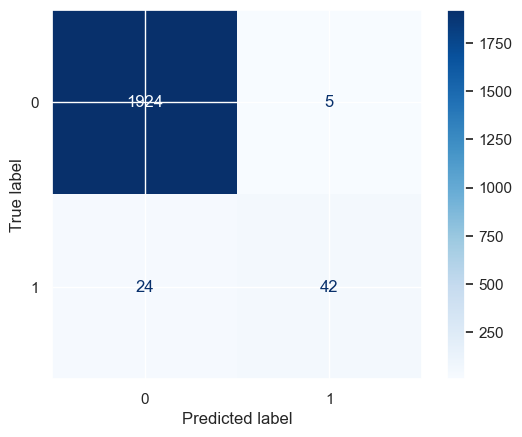

In [61]:
#Ensemble Algorithm
# Gradient Boosting Classifier with all features

start_time = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
train_time = time.time()

predict_GB = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_GB', model, y_test, predict_GB, X_test, start_time, train_time, predict_time)

# Gradient Boosting Classifier with engineered features

start_time = time.time()
model = GradientBoostingClassifier().fit(X_f_train, y_f_train)
train_time = time.time()

predict_GB = model.predict(X_f_test)
predict_time = time.time()

model_scores('bi','bi_GB_f', model, y_f_test, predict_GB, X_f_test, start_time, train_time, predict_time)

In [62]:
# Hyperparameter search for GradientBoostingClassifier

gbc_params = {'max_depth':[5,7,10], 'n_estimators':[100,500,1000], 'learning_rate':[0.01,0.1]}


model = GradientBoostingClassifier()
grid = GridSearchCV(estimator = model, param_grid = gbc_params, n_jobs = -1, cv = cv, scoring = 'recall')
grid_result = grid.fit(X_train, y_train)

print("The best estimator across searched params: ",grid_result.best_estimator_)
print("\n The best score across searched params: ",grid_result.best_score_)
print("\n The best parameters across searched params: ",grid_result.best_params_)


The best estimator across searched params:  GradientBoostingClassifier(max_depth=5, n_estimators=1000)

 The best score across searched params:  0.7377018043684711

 The best parameters across searched params:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}


Accuracy: 98.45%
Recall: 98.45%
Precision: 98.34%
F1-Score: 98.35%
MCC: 73.36%
ROC AUC score: 97.28%
time to train: 1.05340 s
time to predict: 0.00813 s
total: 1.06153 s
start time: 1681675606.98314 s
train time: 1681675608.03654 s
predict time: 1681675608.04467 s


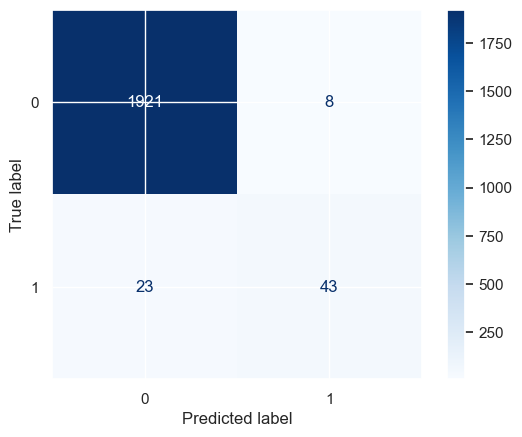

In [63]:
# Gradient Boosting Classifier with hyperparameters

#'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000

start_time = time.time()
model = GradientBoostingClassifier(n_estimators = 100, max_depth = 5, learning_rate = 0.1).fit(X_train, y_train)
train_time = time.time()

predict_GB = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_GB_hyp', model, y_test, predict_GB, X_test, start_time, train_time, predict_time)

[22:06:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.45%
Recall: 98.45%
Precision: 98.34%
F1-Score: 98.30%
MCC: 72.69%
ROC AUC score: 98.69%
time to train: 0.35174 s
time to predict: 0.01005 s
total: 0.36179 s
start time: 1681675611.46151 s
train time: 1681675611.81325 s
predict time: 1681675611.82330 s
[22:06:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.05%
Recall: 98.05%
Precision: 97.91%
F1-Score: 97.96%
MCC: 67.06%
ROC AUC score: 97.72%
time to train: 0.63312 s
time to predict: 0.01004 s
total: 0.64317 s
start time: 1681675611.93373 s
train time: 1681675612.56685 s

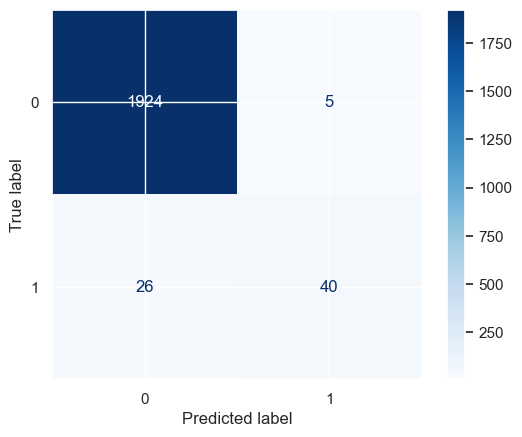

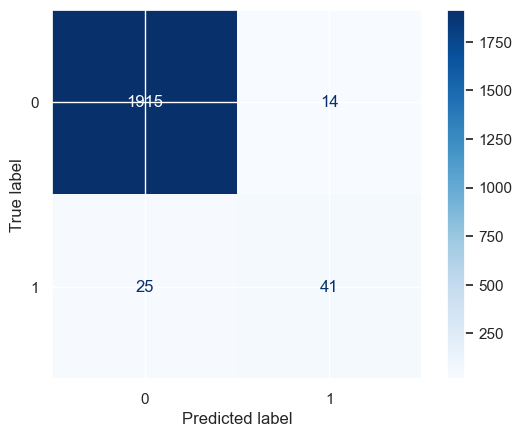

In [64]:
#Ensemble Algorithm
# XGBoost with all features

start_time = time.time()
model = XGBClassifier(n_estimators = 100).fit(X_train,y_train)
train_time = time.time()

predict_XGB = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_XGB', model, y_test, predict_XGB, X_test, start_time, train_time, predict_time)

# XGBoost with engineered features
start_time = time.time()
model = XGBClassifier(n_estimators = 100).fit(X_f_train,y_f_train)
train_time = time.time()

predict_XGB = model.predict(X_f_test)
predict_time = time.time()

model_scores('bi','bi_XGB_f', model, y_f_test, predict_XGB, X_f_test, start_time, train_time, predict_time)

In [65]:
# Hyperparameter search for XGBoost Classifier

xgb_params = {'n_estimators':[300,500,700], 'max_depth':[5,7], 'learning_rate':[0.01,0.1], 'objective':['binary:logistic']}

model = XGBClassifier()
grid = GridSearchCV(estimator = model, param_grid = xgb_params, n_jobs = -1, cv = cv, scoring = 'recall')
grid_result = grid.fit(X_train, y_train)

print("The best estimator across searched params: ",grid_result.best_estimator_)
print("\n The best score across searched params: ",grid_result.best_score_)
print("\n The best parameters across searched params: ",grid_result.best_params_)


[22:10:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The best estimator across searched params:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across searched params:  0.7238366571699905

 The best p

[22:10:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.55%
Recall: 98.55%
Precision: 98.46%
F1-Score: 98.43%
MCC: 74.74%
ROC AUC score: 98.80%
time to train: 1.47386 s
time to predict: 0.00907 s
total: 1.48292 s
start time: 1681675833.35253 s
train time: 1681675834.82638 s
predict time: 1681675834.83545 s


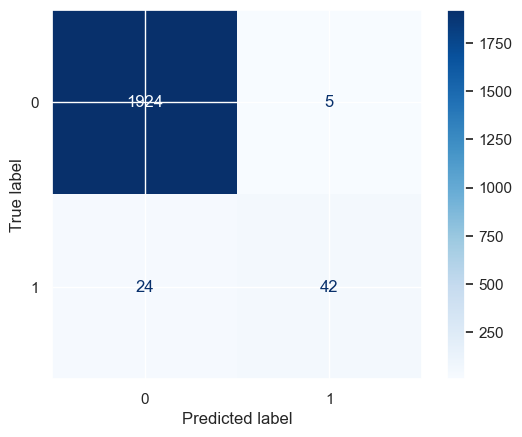

In [66]:
# XGBoost with Hyperparameter

# 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'objective': 'binary:logistic'
start_time = time.time()
model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 7, objective = 'binary:logistic').fit(X_train,y_train)
train_time = time.time()

predict_XGB = model.predict(X_test)
predict_time = time.time()

model_scores('bi','bi_XGB_Hyp', model, y_test, predict_XGB, X_test, start_time, train_time, predict_time)

In [67]:
model_performance

Accuracy  Precision    Recall  F1-Score       MCC   ROC_AUC  \
bi_LR       0.971429   0.971429  0.967013  0.962620  0.373221  0.911298   
bi_LR_f     0.967920   0.967920  0.968950  0.953085  0.171260  0.817640   
bi_LR_Hyp   0.628070   0.628070  0.966245  0.741996  0.203197  0.911117   
bi_DT       0.980451   0.980451  0.979781  0.980079  0.683399  0.828927   
bi_DT_f     0.977444   0.977444  0.977610  0.977525  0.650007  0.827372   
bi_DT_Hyp   0.983960   0.983960  0.982786  0.982569  0.718513  0.918414   
bi_RF       0.981955   0.981955  0.980532  0.979802  0.673334  0.969080   
bi_RF_f     0.984461   0.984461  0.983349  0.983347  0.731123  0.942740   
bi_RF_Hyp   0.981454   0.981454  0.979940  0.979134  0.662164  0.983466   
bi_GB       0.981955   0.981955  0.980355  0.980390  0.681167  0.978828   
bi_GB_f     0.985464   0.985464  0.984568  0.984277  0.747356  0.965067   
bi_GB_hyp   0.984461   0.984461  0.983371  0.983495  0.733594  0.972784   
bi_XGB      0.984461   0.984461  0.983432  0.983033  0.726891  0.986851   
bi_XGB_f    0.980451   0.980451  0.979119  0.979590  0.670644  0.977190   
bi_XGB_Hyp  0.985464   0.985464  0.984568  0.984277  0.747356  0.987951   

            Training_Time  Prediction_Time  
bi_LR            0.144394         0.015673  
bi_LR_f          0.058215         0.003115  
bi_LR_Hyp        0.071746         0.008333  
bi_DT            0.037421         0.005507  
bi_DT_f          0.015618         0.015625  
bi_DT_Hyp        0.031278         0.000000  
bi_RF            0.665459         0.020484  
bi_RF_f          0.634222         0.020413  
bi_RF_Hyp        0.481897         0.020486  
bi_GB            0.658988         0.008134  
bi_GB_f          0.566977         0.008040  
bi_GB_hyp        1.053403         0.008128  
bi_XGB           0.351740         0.010053  
bi_XGB_f         0.633125         0.010041  
bi_XGB_Hyp       1.473856         0.009068

## 5. **Multi-class Classification** <a id="multi"></a> 

As seen from the results of binary classification, including engineered features results in a poor performing model. Hence this is skipped for Mult-class classification.

In [72]:
X = df.loc[:, ['Type','Air temperature','Process temperature','Torque','Rotational speed','Tool wear']]
y = df['Failure type']
# split dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Accuracy: 96.59%
Recall: 96.59%
Precision: 94.45%
F1-Score: 95.05%
MCC: 13.62%
time to train: 0.13154 s
time to predict: 0.00000 s
total: 0.13154 s
start time: 1681676130.05911 s
train time: 1681676130.19065 s
predict time: 1681676130.19065 s


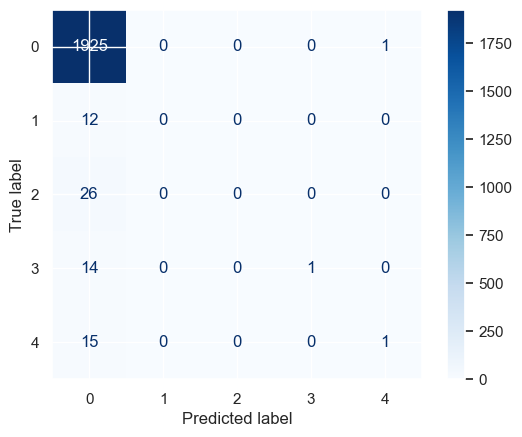

In [73]:
# Logistic Regression

start_time = time.time()
model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)
train_time = time.time()

predict_LR = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_LR', model, y_test, predict_LR, X_test, start_time, train_time, predict_time)

### Logistic Regression with Hyperparameters

Cannot be used as all the failures are to be treated equally important!

Accuracy: 97.59%
Recall: 97.59%
Precision: 97.39%
F1-Score: 97.49%
MCC: 62.67%
time to train: 0.01860 s
time to predict: 0.01566 s
total: 0.03426 s
start time: 1681676149.10862 s
train time: 1681676149.12723 s
predict time: 1681676149.14289 s


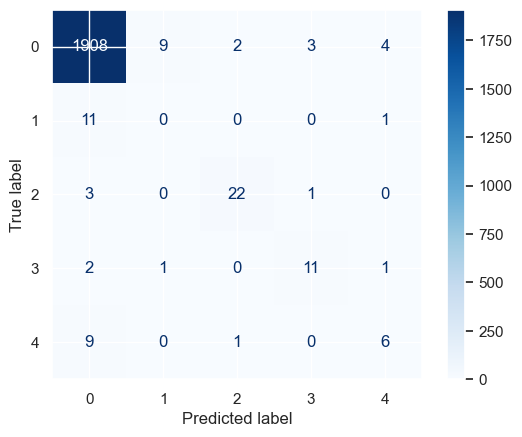

In [75]:
# Decision Tree Classifier

start_time = time.time()
model = DecisionTreeClassifier().fit(X_train, y_train)
train_time = time.time()

predict_DT = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_DT', model, y_test, predict_DT, X_test, start_time, train_time, predict_time)

Accuracy: 98.15%
Recall: 98.15%
Precision: 97.68%
F1-Score: 97.84%
MCC: 70.05%
time to train: 0.01964 s
time to predict: 0.00000 s
total: 0.01964 s
start time: 1681676154.19055 s
train time: 1681676154.21019 s
predict time: 1681676154.21019 s


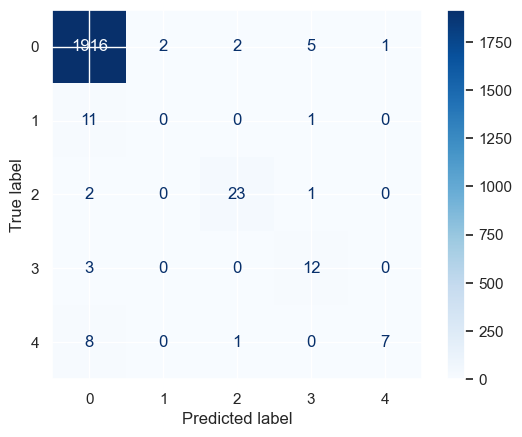

In [76]:
# Decision Tree Classifier with Hyperparameters
# 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'random_state': 0
start_time = time.time()
model = DecisionTreeClassifier(criterion='gini', max_depth= 10, min_samples_leaf= 5, random_state= 0).fit(X_train, y_train)
train_time = time.time()

predict_DT = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_DT_Hyp', model, y_test, predict_DT, X_test, start_time, train_time, predict_time)

Accuracy: 98.05%
Recall: 98.05%
Precision: 97.44%
F1-Score: 97.65%
MCC: 66.21%
time to train: 0.49892 s
time to predict: 0.03054 s
total: 0.52947 s
start time: 1681676162.87855 s
train time: 1681676163.37747 s
predict time: 1681676163.40802 s


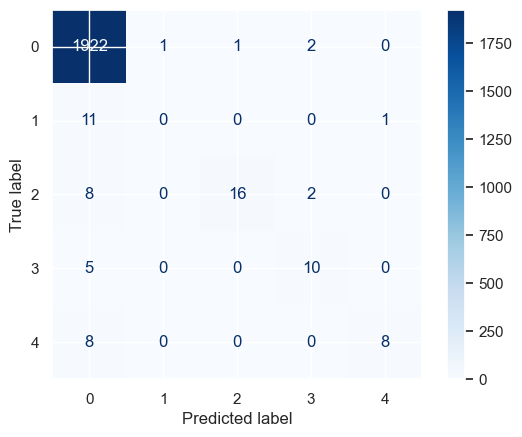

In [77]:
# Random Forest Classifier

start_time = time.time()
model = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
train_time = time.time()

predict_RF = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_RF', model, y_test, predict_RF, X_test, start_time, train_time, predict_time)

Accuracy: 97.89%
Recall: 97.89%
Precision: 97.28%
F1-Score: 97.37%
MCC: 62.48%
time to train: 0.48329 s
time to predict: 0.02847 s
total: 0.51176 s
start time: 1681676168.15741 s
train time: 1681676168.64070 s
predict time: 1681676168.66916 s


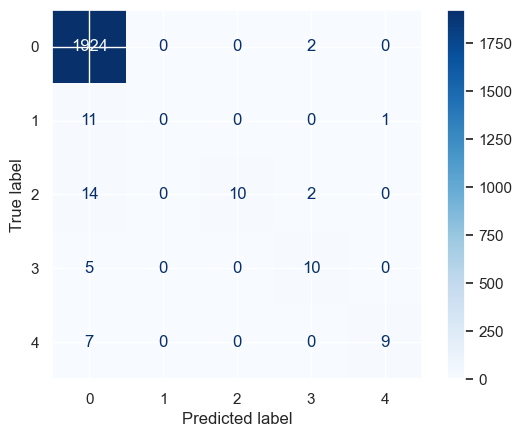

In [78]:
# Random Forest Classifier with Hyperparameters
# 'max_depth': 10, 'n_estimators': 100, 'random_state': 0
start_time = time.time()
model = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 0).fit(X_train, y_train)
train_time = time.time()

predict_RF = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_RF_Hyp', model, y_test, predict_RF, X_test, start_time, train_time, predict_time)

Accuracy: 98.40%
Recall: 98.40%
Precision: 98.34%
F1-Score: 98.12%
MCC: 73.81%
time to train: 3.21223 s
time to predict: 0.01013 s
total: 3.22235 s
start time: 1681676172.54948 s
train time: 1681676175.76171 s
predict time: 1681676175.77184 s


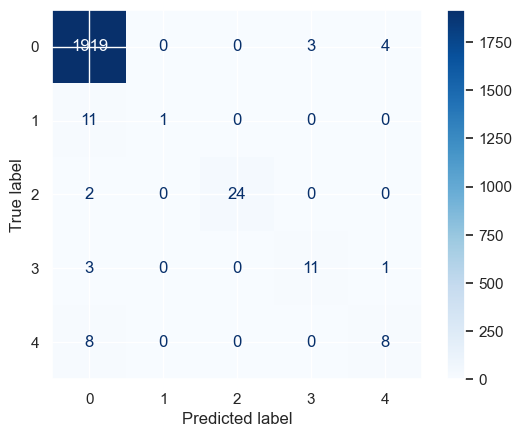

In [79]:
# Gradient Boosting Classifier

start_time = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
train_time = time.time()

predict_GB = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_GB', model, y_test, predict_GB, X_test, start_time, train_time, predict_time)

Accuracy: 98.40%
Recall: 98.40%
Precision: 97.99%
F1-Score: 98.17%
MCC: 74.45%
time to train: 4.99623 s
time to predict: 0.01018 s
total: 5.00641 s
start time: 1681676178.99097 s
train time: 1681676183.98720 s
predict time: 1681676183.99738 s


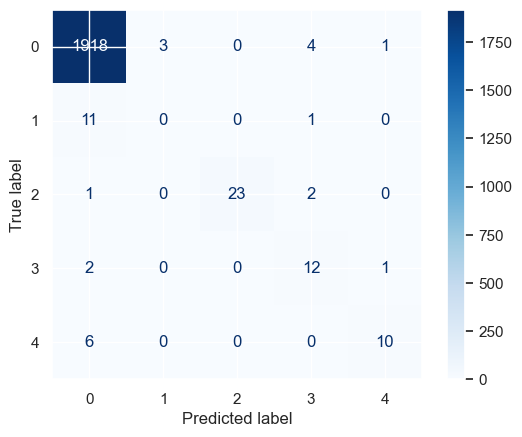

In [80]:
# Gradient Boosting Classifier with hyperparameters

#'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000

start_time = time.time()
model = GradientBoostingClassifier(n_estimators = 100, max_depth = 5, learning_rate = 0.1).fit(X_train, y_train)
train_time = time.time()

predict_GB = model.predict(X_test)
predict_time = time.time()

model_scores('mul','multi_GB_hyp', model, y_test, predict_GB, X_test, start_time, train_time, predict_time)

[22:16:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.60%
Recall: 98.60%
Precision: 98.17%
F1-Score: 98.37%
MCC: 78.05%
time to train: 0.86201 s
time to predict: 0.00802 s
total: 0.87002 s
start time: 1681676187.61133 s
train time: 1681676188.47334 s
predict time: 1681676188.48135 s


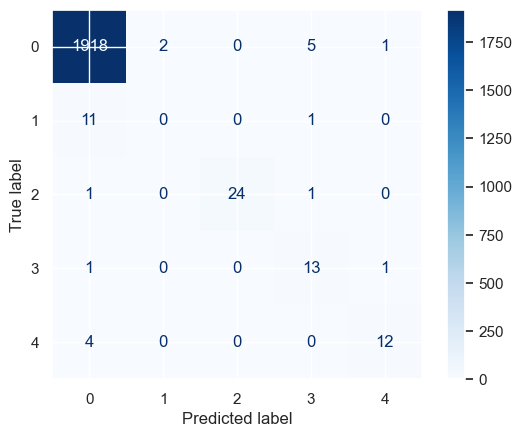

In [81]:
# XGBoost with all features

start_time = time.time()
model = XGBClassifier(n_estimators = 100).fit(X_train,y_train)
train_time = time.time()

predict_XGB = model.predict(X_test)
predict_time = time.time()

model_scores('mul','mul_XGB', model, y_test, predict_XGB, X_test, start_time, train_time, predict_time)

[22:16:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.55%
Recall: 98.55%
Precision: 98.03%
F1-Score: 98.29%
MCC: 77.13%
time to train: 3.34371 s
time to predict: 0.01002 s
total: 3.35373 s
start time: 1681676197.89705 s
train time: 1681676201.24076 s
predict time: 1681676201.25078 s


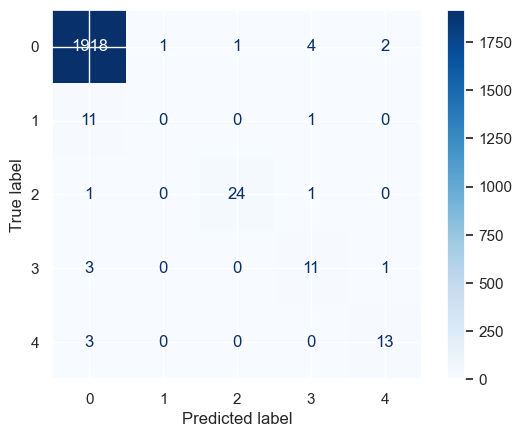

In [82]:
# XGBoost with Hyperparameter

# 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'objective': 'binary:logistic'
start_time = time.time()
model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 7, objective = 'binary:logistic').fit(X_train,y_train)
train_time = time.time()

predict_XGB = model.predict(X_test)
predict_time = time.time()

model_scores('mul','mul_XGB_Hyp', model, y_test, predict_XGB, X_test, start_time, train_time, predict_time)

## 6. **Resampling** <a id="resample"></a> 

In [83]:
from imblearn.over_sampling import RandomOverSampler

oversamp = RandomOverSampler(random_state=0)

# split dataset into train and test
X = df.loc[:, ['Type','Air temperature','Process temperature','Torque','Rotational speed','Tool wear']]
y = df['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

X_train, y_train = oversamp.fit_resample(X_train, y_train)

Accuracy: 83.11%
Recall: 83.11%
Precision: 96.38%
F1-Score: 88.30%
MCC: 29.01%
ROC AUC score: 91.23%
time to train: 0.06903 s
time to predict: 0.00000 s
total: 0.06903 s
start time: 1681676225.67117 s
train time: 1681676225.74020 s
predict time: 1681676225.74020 s


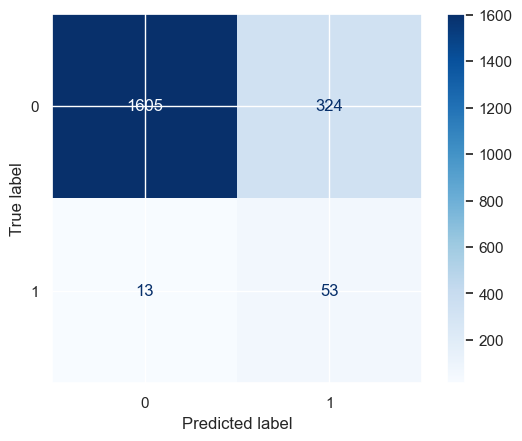

In [84]:
# Binary Logistic Regression - Oversampling 

start_time = time.time()
model = LogisticRegression().fit(X_train, y_train)
train_time = time.time()

predict_LR = model.predict(X_test)
predict_time = time.time()

model_scores('bi','ovr_bi_LR', model, y_test, predict_LR, X_test, start_time, train_time, predict_time)

Accuracy: 97.64%
Recall: 97.64%
Precision: 97.33%
F1-Score: 97.38%
MCC: 56.58%
ROC AUC score: 72.44%
time to train: 0.02214 s
time to predict: 0.00000 s
total: 0.02214 s
start time: 1681676229.05302 s
train time: 1681676229.07516 s
predict time: 1681676229.07516 s


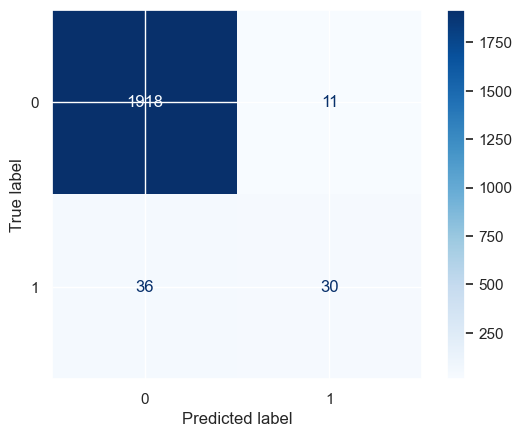

In [85]:
# Binary Decision Tree Classifier - Oversampling 

start_time = time.time()
model = DecisionTreeClassifier().fit(X_train, y_train)
train_time = time.time()

predict_DT = model.predict(X_test)
predict_time = time.time()

model_scores('bi','ovr_bi_DT', model, y_test, predict_DT, X_test, start_time, train_time, predict_time)

Accuracy: 98.30%
Recall: 98.30%
Precision: 98.16%
F1-Score: 98.15%
MCC: 69.98%
ROC AUC score: 97.75%
time to train: 0.67263 s
time to predict: 0.02042 s
total: 0.69305 s
start time: 1681676231.46192 s
train time: 1681676232.13455 s
predict time: 1681676232.15497 s


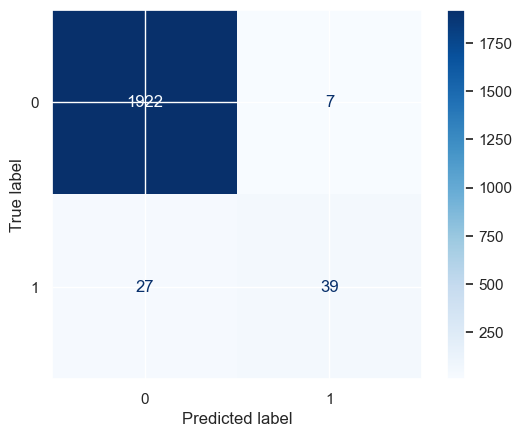

In [86]:
# Binary Random Forest Classifier - Oversampling 

start_time = time.time()
model = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
train_time = time.time()

predict_RF = model.predict(X_test)
predict_time = time.time()

model_scores('bi','ovr_bi_RF', model, y_test, predict_RF, X_test, start_time, train_time, predict_time)

Accuracy: 94.04%
Recall: 94.04%
Precision: 97.58%
F1-Score: 95.30%
MCC: 54.70%
ROC AUC score: 98.16%
time to train: 1.01433 s
time to predict: 0.00812 s
total: 1.02245 s
start time: 1681676235.62864 s
train time: 1681676236.64296 s
predict time: 1681676236.65109 s


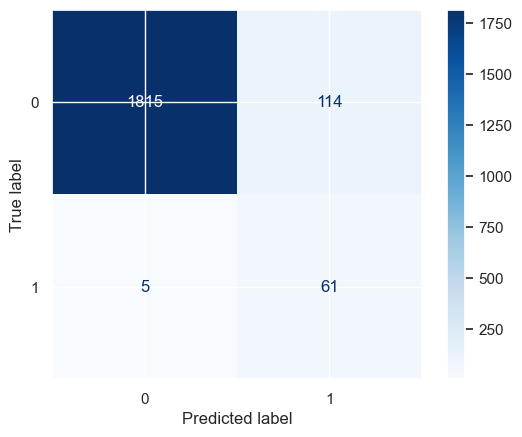

In [87]:
# Binary Gradient Boosting Classifier - Oversampling 

start_time = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
train_time = time.time()

predict_GB = model.predict(X_test)
predict_time = time.time()

model_scores('bi','ovr_bi_GB', model, y_test, predict_GB, X_test, start_time, train_time, predict_time)

[22:17:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.50%
Recall: 98.50%
Precision: 98.44%
F1-Score: 98.46%
MCC: 75.51%
ROC AUC score: 98.85%
time to train: 0.44991 s
time to predict: 0.01003 s
total: 0.45994 s
start time: 1681676239.49641 s
train time: 1681676239.94632 s
predict time: 1681676239.95635 s


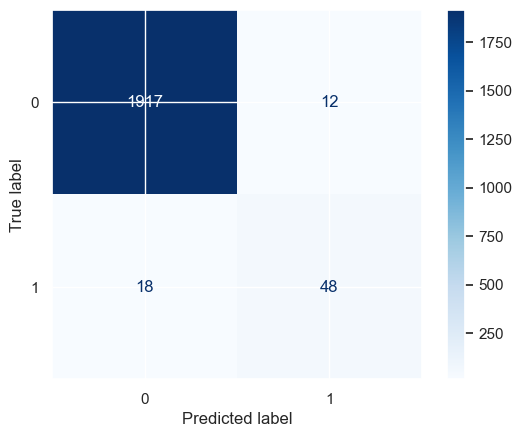

In [88]:
# Binary XGBoost - Oversampling

start_time = time.time()
model = XGBClassifier(n_estimators = 100).fit(X_train,y_train)
train_time = time.time()

predict_XGB = model.predict(X_test)
predict_time = time.time()

model_scores('bi','ovr_bi_XGB', model, y_test, predict_XGB, X_test, start_time, train_time, predict_time)

In [89]:
# Multi-class classification with oversampling

X = df.loc[:, ['Type','Air temperature','Process temperature','Torque','Rotational speed','Tool wear']]
y = df['Failure type']

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, y_train = oversamp.fit_resample(X_train, y_train)

Accuracy: 77.69%
Recall: 77.69%
Precision: 96.91%
F1-Score: 84.98%
MCC: 31.40%
time to train: 0.59321 s
time to predict: 0.00205 s
total: 0.59525 s
start time: 1681676275.71618 s
train time: 1681676276.30939 s
predict time: 1681676276.31144 s


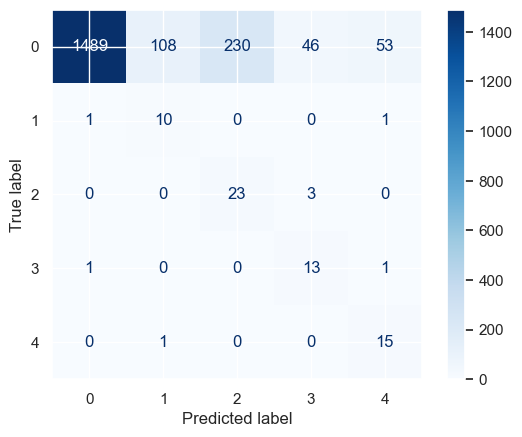

In [90]:
# Multi-class Logistic Regression - Oversampling

start_time = time.time()
model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)
train_time = time.time()

predict_LR = model.predict(X_test)
predict_time = time.time()

model_scores('mul','ovr_multi_LR', model, y_test, predict_LR, X_test, start_time, train_time, predict_time)

Accuracy: 97.49%
Recall: 97.49%
Precision: 97.33%
F1-Score: 97.40%
MCC: 61.11%
time to train: 0.04861 s
time to predict: 0.00000 s
total: 0.04861 s
start time: 1681676279.57575 s
train time: 1681676279.62435 s
predict time: 1681676279.62435 s


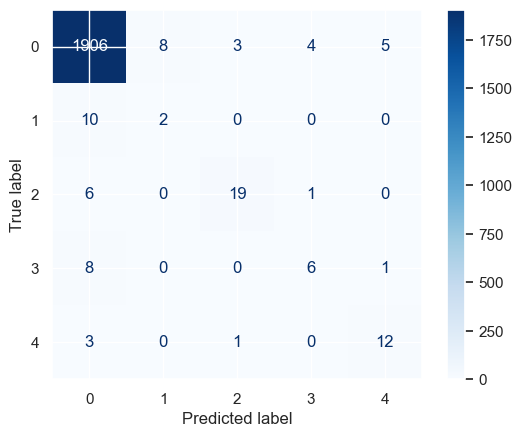

In [91]:
# Multi-class Decision Tree Classifier - Oversampling 

start_time = time.time()
model = DecisionTreeClassifier().fit(X_train, y_train)
train_time = time.time()

predict_DT = model.predict(X_test)
predict_time = time.time()

model_scores('mul','ovr_multi_DT', model, y_test, predict_DT, X_test, start_time, train_time, predict_time)

Accuracy: 98.30%
Recall: 98.30%
Precision: 97.69%
F1-Score: 97.96%
MCC: 71.40%
time to train: 1.33736 s
time to predict: 0.02043 s
total: 1.35779 s
start time: 1681676284.22112 s
train time: 1681676285.55848 s
predict time: 1681676285.57891 s


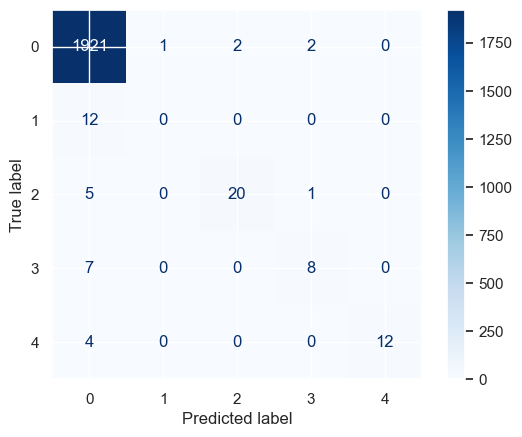

In [92]:
# Multi-class Random Forest Classifier - Oversampling 

start_time = time.time()
model = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
train_time = time.time()

predict_RF = model.predict(X_test)
predict_time = time.time()

model_scores('mul','ovr_multi_RF', model, y_test, predict_RF, X_test, start_time, train_time, predict_time)

Accuracy: 95.94%
Recall: 95.94%
Precision: 98.11%
F1-Score: 96.87%
MCC: 61.30%
time to train: 11.73059 s
time to predict: 0.01017 s
total: 11.74076 s
start time: 1681676288.07305 s
train time: 1681676299.80364 s
predict time: 1681676299.81381 s


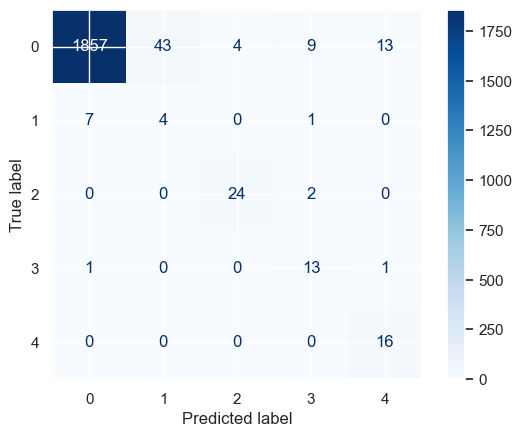

In [93]:
# Multi-class Gradient Boosting Classifier - Oversampling 

start_time = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
train_time = time.time()

predict_GB = model.predict(X_test)
predict_time = time.time()

model_scores('mul','ovr_multi_GB', model, y_test, predict_GB, X_test, start_time, train_time, predict_time)

[22:18:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.20%
Recall: 98.20%
Precision: 98.28%
F1-Score: 98.21%
MCC: 75.08%
time to train: 2.77010 s
time to predict: 0.00000 s
total: 2.77010 s
start time: 1681676304.89386 s
train time: 1681676307.66396 s
predict time: 1681676307.66396 s


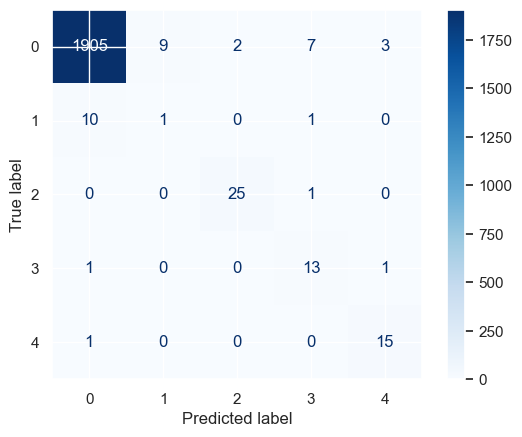

In [94]:
# Multi-class XGBoost - Oversampling 

start_time = time.time()
model = XGBClassifier(n_estimators = 100).fit(X_train,y_train)
train_time = time.time()

predict_XGB = model.predict(X_test)
predict_time = time.time()

model_scores('mul','ovr_mul_XGB', model, y_test, predict_XGB, X_test, start_time, train_time, predict_time)

In [95]:
model_performance

Accuracy  Precision    Recall  F1-Score       MCC   ROC_AUC  \
bi_LR         0.971429   0.971429  0.967013  0.962620  0.373221  0.911298   
bi_LR_f       0.967920   0.967920  0.968950  0.953085  0.171260   0.81764   
bi_LR_Hyp     0.628070   0.628070  0.966245  0.741996  0.203197  0.911117   
bi_DT         0.980451   0.980451  0.979781  0.980079  0.683399  0.828927   
bi_DT_f       0.977444   0.977444  0.977610  0.977525  0.650007  0.827372   
bi_DT_Hyp     0.983960   0.983960  0.982786  0.982569  0.718513  0.918414   
bi_RF         0.981955   0.981955  0.980532  0.979802  0.673334   0.96908   
bi_RF_f       0.984461   0.984461  0.983349  0.983347  0.731123   0.94274   
bi_RF_Hyp     0.981454   0.981454  0.979940  0.979134  0.662164  0.983466   
bi_GB         0.981955   0.981955  0.980355  0.980390  0.681167  0.978828   
bi_GB_f       0.985464   0.985464  0.984568  0.984277  0.747356  0.965067   
bi_GB_hyp     0.984461   0.984461  0.983371  0.983495  0.733594  0.972784   
bi_XGB        0.984461   0.984461  0.983432  0.983033  0.726891  0.986851   
bi_XGB_f      0.980451   0.980451  0.979119  0.979590  0.670644   0.97719   
bi_XGB_Hyp    0.985464   0.985464  0.984568  0.984277  0.747356  0.987951   
multi_LR      0.965915   0.965915  0.944471  0.950489  0.136171        NA   
multi_DT      0.975940   0.975940  0.973920  0.974851  0.626708        NA   
multi_DT_Hyp  0.981454   0.981454  0.976765  0.978438  0.700464        NA   
multi_RF      0.980451   0.980451  0.974369  0.976473  0.662147        NA   
multi_RF_Hyp  0.978947   0.978947  0.972819  0.973705  0.624765        NA   
multi_GB      0.983960   0.983960  0.983379  0.981244  0.738096        NA   
multi_GB_hyp  0.983960   0.983960  0.979915  0.981688  0.744503        NA   
mul_XGB       0.985965   0.985965  0.981726  0.983675  0.780547        NA   
mul_XGB_Hyp   0.985464   0.985464  0.980330  0.982866  0.771324        NA   
ovr_bi_LR     0.831078   0.831078  0.963799  0.882967  0.290134  0.912311   
ovr_bi_DT     0.976441   0.976441  0.973310  0.973765  0.565820  0.724422   
ovr_bi_RF     0.982957   0.982957  0.981571  0.981480  0.699840  0.977477   
ovr_bi_GB     0.940351   0.940351  0.975793  0.952973  0.546981  0.981624   
ovr_bi_XGB    0.984962   0.984962  0.984389  0.984616  0.755072  0.988454   
ovr_multi_LR  0.776942   0.776942  0.969104  0.849785  0.313958        NA   
ovr_multi_DT  0.974937   0.974937  0.973346  0.973987  0.611129        NA   
ovr_multi_RF  0.982957   0.982957  0.976880  0.979554  0.714005        NA   
ovr_multi_GB  0.959398   0.959398  0.981142  0.968671  0.612968        NA   
ovr_mul_XGB   0.981955   0.981955  0.982814  0.982123  0.750785        NA   

              Training_Time  Prediction_Time  
bi_LR              0.144394         0.015673  
bi_LR_f            0.058215         0.003115  
bi_LR_Hyp          0.071746         0.008333  
bi_DT              0.037421         0.005507  
bi_DT_f            0.015618         0.015625  
bi_DT_Hyp          0.031278         0.000000  
bi_RF              0.665459         0.020484  
bi_RF_f            0.634222         0.020413  
bi_RF_Hyp          0.481897         0.020486  
bi_GB              0.658988         0.008134  
bi_GB_f            0.566977         0.008040  
bi_GB_hyp          1.053403         0.008128  
bi_XGB             0.351740         0.010053  
bi_XGB_f           0.633125         0.010041  
bi_XGB_Hyp         1.473856         0.009068  
multi_LR           0.131536         0.000000  
multi_DT           0.018602         0.015661  
multi_DT_Hyp       0.019642         0.000000  
multi_RF           0.498925         0.030545  
multi_RF_Hyp       0.483291         0.028466  
multi_GB           3.212227         0.010127  
multi_GB_hyp       4.996232         0.010177  
mul_XGB            0.862006         0.008016  
mul_XGB_Hyp        3.343707         0.010025  
ovr_bi_LR          0.069027         0.000000  
ovr_bi_DT          0.022135         0.000000  
ovr_bi_RF          0.672632         0.020417  
ov

## 7. **Conclusion** <a id="conclusion"></a> 
In conclusion, the dataset is evaluated against Logistic Regression, Decision Tree Classifier, Random Forest Classifier, Gradient Boosting Classifier and Extreme Gradient Boosting Classifier with variations of 
1. All the features,
2. Engineered features,
3. Tuned Hyperparameters
4. Oversampling the dataset.
Also the following questions are answered, 
1. Which model performs the best for binary classification?
    Extreme Gradient Boosting Classifier with tuned hyperparameters proves to be the best performing model for binary classification. Following are the evaluations for the model.
    Accuracy 0.985464 	
    Precision 0.985464 	
    Recall 0.984568 	
    F1 Score 0.984277 	
    MCC 0.747356 	
    ROC_AUC 0.987951
    
2. Which model performs the best for multi-class classification?
    Extreme Gradient Boosting Classifier with and without tuned hyperparameters result in similar performing models and fare the best compared to other models for multi-class classification. Following are the evaluations for the model.
    XGB:
        Accuracy 0.985965 	
        Precision 0.985965 	
        Recall 0.981726 	
        F1 Score 0.983675 	
        MCC 0.780547 	
        
   XGB with tuned Hyperparameters:
        Accuracy 0.985464 	
        Precision 0.985464 	
        Recall 0.980330 	
        F1 Score 0.982866 	
        MCC 0.771324 	
        
3. Which features contribute to failure? Which features result in a specific failure?
    TWF: Quality variants add 5/3/2 min of tool wear. Depends mainly on the features Tool wear and Type of the machine. Occured 120 times in the dataset where the tool wear ranged between 200 and 240 mins.
    PWF: Mainly dependent on Torque and Rotational speed. When the product of Torque and Rotational speed is either less than 3500 or greater than 9000, it results in Power Failure. Occured 97 times in the dataset. 
    HSF: Mainly dependent on the air temperature and process temperature difference. When the range of (Air Temperature – Process Temperature) is less than 8.6 K and Rotational speed is less than 1380 rpm, the Heat dissipation failure is flagged.
    OSF: Dependent on the type of the machine, the Tool wear and Torque:
    For L – Tool wear * Torque > 11000, 
        M - > 12000, 
        H - 13000 
    Occured at 98 points in dataset.
    RNF: Random no particular feature results in random failure
    
4. Does re-sampling really help?
    Based on the performance metrics, it can be clearly seen that the re-sampling did not result in better performance for both binary and multi-class classification.
    
6. How to evaluate the performance metrics?
    Accuracy
    Precision
    Recall
    F1 Score
    MCC

7. Hyperparameter tuning?
    Hyperparameter tuning led to a slight improvement in the performance for models both binary and multi-class classification.
